In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import seaborn as sns
import xarray as xr
xr.set_options(display_style='text'); # Show xarray.Dataset representation as text

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10}) # Set plot font size to 16pt

import numpy as np
import time
from scipy.spatial import cKDTree

from pykrige import OrdinaryKriging as OKpy
import tqdm
import os
import datetime
os.chdir("..")
import pandas as pd
import matplotlib as mpl

# OPENSENSE Sandbox tools 
# ToDo: Set link from local to github
from Algo2_PWSPYQC_master.Geneve import PWSpyqcFunctions as pws_pyqc
import statsmodels.api as sm
import Funcs as funcs

# Link to the data
main_dir = "Data/"


In [2]:
os.getcwd()

'c:\\Users\\arian\\OneDrive\\Documents\\cours\\M1S2\\design_gitlab'

## Importing data

In [3]:
df_pws_flagged = pws_pyqc.read_pcp_csv_file('Data/Output_algo_2/flagged_csv.csv',sep_type=',',
                           index_col=0) 
accepted_pws = pws_pyqc.read_pcp_csv_file('Data/Output_algo_2/netatmo_accepted.csv',sep_type=',',
                           index_col=0) 
df_pws_bias_corrected = pws_pyqc.read_pcp_csv_file('Data/Output_algo_2/bias_corrected.csv',sep_type=',',
                           index_col=0) 


In [4]:
# read primary network 1
print('Reading first primary network data')
# pyqc.read_pcp_csv_file has 'latin-1' encoding in PWSpyqcFunctions.py
in_primary_pcp = pws_pyqc.read_pcp_csv_file(path_to_file="Data/Clean_data/oceau_hour_after_april.csv",
                           sep_type=',',
                           index_col=0)

# pyqc uses EPSG:25832, for Netherlands EPSG:28531 is used!
# Reads coordinate file and additionally coverts Lat/Lon to UTM 32
df_prim_coords, prim_coords_xy = pws_pyqc.read_metadata_csv_file("Data/Clean_data/Metadata_oceau.csv",
                                                           sep_type=',', index_col=0,)
df_prim_coords.index = in_primary_pcp.columns
# read pws data
print('Reading PWS data')
df_pws_pcp_hourly = pws_pyqc.read_pcp_csv_file(
        path_to_file="Data/Clean_data/pws_hourly_total.csv",
                           sep_type=',',
                           index_col=0)
    
df_pws_coords, pws_coords_xy = pws_pyqc.read_metadata_csv_file(
        path_to_file="Data/Clean_data/metatablehour_tot.csv",
                           sep_type=',',ID_index =True,
                           index_col=0)


Reading first primary network data
Reading PWS data


### importation des données de PWSQC

In [5]:
def read_csv_algo1(path,df_pws_pcp_hourly =df_pws_pcp_hourly,ignore_index = False):
    if ignore_index:
        df = pd.read_csv(path).iloc[:,1:]
    else :
        df = pd.read_csv(path)
    df.columns =df_pws_pcp_hourly.columns
    #remove last line because data from oceau stop on 2023 and not in 2024
    df  = df.iloc[:-1,:]
    df.index = df_pws_pcp_hourly.index
    return df
HI_flags = read_csv_algo1("Data/Output_algo_1/HI_flags.csv")
FZ_flags = read_csv_algo1("Data/Output_algo_1/FZ_flags.csv")
SO_flags = read_csv_algo1("Data/Output_algo_1/SO_flags.csv")

In [6]:
bias_correction_table = read_csv_algo1("Data/Output_algo_1/biascorrectiontable.csv", ignore_index=True)

##### Création des dataframe en filtre non-strict

In [7]:
HI_mask = HI_flags == 1
FZ_mask = FZ_flags == 1
SO_mask = SO_flags == 1

algo_1_pws_pcp_hourly = df_pws_pcp_hourly.copy(deep=True)
algo_1_pws_pcp_hourly[HI_mask] = np.NaN
algo_1_pws_pcp_hourly[FZ_mask] = np.NaN
algo_1_pws_pcp_hourly[SO_mask] = np.NaN
algo_1_pws_pcp_hourly

05_00_00_00_03_84  05_00_00_00_04_44  05_00_00_00_0b_98  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN              0.000                NaN   
2023-04-01 11:00:00                NaN              0.505                NaN   
2023-04-01 12:00:00                NaN                NaN                NaN   
2023-04-01 13:00:00                NaN              0.101                NaN   
...                                ...                ...                ...   
2023-12-31 19:00:00                NaN                NaN                NaN   
2023-12-31 20:00:00                NaN                NaN                NaN   
2023-12-31 21:00:00                NaN                NaN                NaN   
2023-12-31 22:00:00                NaN                NaN                NaN   
2023-12-31 23:00:00                NaN                NaN                NaN   

                     05_00_00_00_15_46  05_00_00_00_15_e6  05_00_00_00_17_e0  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN                NaN                NaN   
2023-04-01 12:00:00                NaN                NaN                NaN   
2023-04-01 13:00:00                NaN                NaN                NaN   
...                                ...                ...                ...   
2023-12-31 19:00:00                NaN                NaN                NaN   
2023-12-31 20:00:00                NaN                NaN                NaN   
2023-12-31 21:00:00                NaN                NaN                NaN   
2023-12-31 22:00:00                NaN                0.0                NaN   
2023-12-31 23:00:00                NaN                0.0                NaN   

                     05_00_00_00_17_f4  05_00_00_00_1d_5e  05_00_00_00_2c_4a  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN                NaN                0.0   
2023-04-01 12:00:00                NaN              0.606                NaN   
2023-04-01 13:00:00                NaN                NaN                NaN   
...                                ...                ...                ...   
2023-12-31 19:00:00                NaN                NaN                NaN   
2023-12-31 20:00:00                NaN                NaN                NaN   
2023-12-31 21:00:00                NaN                NaN                NaN   
2023-12-31 22:00:00                NaN                NaN                NaN   
2023-12-31 23:00:00                NaN                NaN                NaN   

                     05_00_00_00_30_20  ...  05_00_00_0a_c1_6e  \
time                                    ...                      
2023-04-01 09:00:00                NaN  ...                NaN   
2023-04-01 10:00:00                NaN  ...                NaN   
2023-04-01 11:00:00                NaN  ...                NaN   
2023-04-01 12:00:00                NaN  ...                NaN   
2023-04-01 13:00:00                NaN  ...                NaN   
...                                ...  ...                ...   
2023-12-31 19:00:00                NaN  ...                NaN   
2023-12-31 20:00:00                NaN  ...                NaN   
2023-12-31 21:00:00                NaN  ...                NaN   
2023-12-31 22:00:00                NaN  ...                NaN   
2023-12-31 23:00:00                NaN  ...                NaN   

                     05_00_00_0a_c5_2a 

In [8]:
print(f"Le nombre de données enlevées en filtre non-strict par l'algo1 {df_pws_pcp_hourly.count().sum() -algo_1_pws_pcp_hourly.count().sum()}")
print(f"Cela représente {(df_pws_pcp_hourly.count().sum() -algo_1_pws_pcp_hourly.count().sum())/df_pws_pcp_hourly.count().sum() *100} pourcent du nombre total de données")

Le nombre de données enlevées en filtre non-strict par l'algo1 58945
Cela représente 11.244282002662993 pourcent du nombre total de données


In [9]:
#afin de pouvoir comparer avec les résultats pws-pyqc on regarde combien de données sont enlevées sur les stations acceptées
algo1_onaccepted = algo_1_pws_pcp_hourly.loc[:,accepted_pws.columns]

In [10]:
print(f"Le nombre de données enlevées en filtre non-strict par l'algo1 sur les stations acceptées {accepted_pws.count().sum() -algo1_onaccepted.count().sum()}")
print(f"Cela représente {(accepted_pws.count().sum() -algo1_onaccepted.count().sum())/accepted_pws.count().sum() *100} pourcent du nombre total de données des stations acceptées")

Le nombre de données enlevées en filtre non-strict par l'algo1 sur les stations acceptées 17925
Cela représente 4.515147469628234 pourcent du nombre total de données des stations acceptées


In [11]:
algo_1_pws_pcp_hourly.to_csv("Data/Output_algo_1/final_algo1.csv")

##### Création des dataframe en filtre strict

In [12]:
HI_mask_strict = (HI_flags == 1) | (HI_flags == -1)
FZ_mask_strict = (FZ_flags == 1) | (FZ_flags == -1)
SO_mask_strict = (SO_flags == 1) | (SO_flags == -1)

algo_1_strict = df_pws_pcp_hourly.copy(deep=True)
algo_1_strict[HI_mask_strict] = np.NaN
algo_1_strict[FZ_mask_strict] = np.NaN
algo_1_strict[SO_mask_strict] = np.NaN
algo_1_strict

05_00_00_00_03_84  05_00_00_00_04_44  05_00_00_00_0b_98  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN                NaN                NaN   
2023-04-01 12:00:00                NaN                NaN                NaN   
2023-04-01 13:00:00                NaN                NaN                NaN   
...                                ...                ...                ...   
2023-12-31 19:00:00                NaN                NaN                NaN   
2023-12-31 20:00:00                NaN                NaN                NaN   
2023-12-31 21:00:00                NaN                NaN                NaN   
2023-12-31 22:00:00                NaN                NaN                NaN   
2023-12-31 23:00:00                NaN                NaN                NaN   

                     05_00_00_00_15_46  05_00_00_00_15_e6  05_00_00_00_17_e0  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN                NaN                NaN   
2023-04-01 12:00:00                NaN                NaN                NaN   
2023-04-01 13:00:00                NaN                NaN                NaN   
...                                ...                ...                ...   
2023-12-31 19:00:00                NaN                NaN                NaN   
2023-12-31 20:00:00                NaN                NaN                NaN   
2023-12-31 21:00:00                NaN                NaN                NaN   
2023-12-31 22:00:00                NaN                0.0                NaN   
2023-12-31 23:00:00                NaN                0.0                NaN   

                     05_00_00_00_17_f4  05_00_00_00_1d_5e  05_00_00_00_2c_4a  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN                NaN                NaN   
2023-04-01 12:00:00                NaN                NaN                NaN   
2023-04-01 13:00:00                NaN                NaN                NaN   
...                                ...                ...                ...   
2023-12-31 19:00:00                NaN                NaN                NaN   
2023-12-31 20:00:00                NaN                NaN                NaN   
2023-12-31 21:00:00                NaN                NaN                NaN   
2023-12-31 22:00:00                NaN                NaN                NaN   
2023-12-31 23:00:00                NaN                NaN                NaN   

                     05_00_00_00_30_20  ...  05_00_00_0a_c1_6e  \
time                                    ...                      
2023-04-01 09:00:00                NaN  ...                NaN   
2023-04-01 10:00:00                NaN  ...                NaN   
2023-04-01 11:00:00                NaN  ...                NaN   
2023-04-01 12:00:00                NaN  ...                NaN   
2023-04-01 13:00:00                NaN  ...                NaN   
...                                ...  ...                ...   
2023-12-31 19:00:00                NaN  ...                NaN   
2023-12-31 20:00:00                NaN  ...                NaN   
2023-12-31 21:00:00                NaN  ...                NaN   
2023-12-31 22:00:00                NaN  ...                NaN   
2023-12-31 23:00:00                NaN  ...                NaN   

                     05_00_00_0a_c5_2a 

In [13]:
print(f"Le nombre de données enlevées en filtre strict par l'algo1 {df_pws_pcp_hourly.count().sum() -algo_1_strict.count().sum()}")
print(f"Cela représente {(df_pws_pcp_hourly.count().sum() -algo_1_strict.count().sum())/df_pws_pcp_hourly.count().sum() *100} pourcent du nombre total de données")

Le nombre de données enlevées en filtre strict par l'algo1 116079
Cela représente 22.143099679143567 pourcent du nombre total de données


In [14]:
algo1_strict_onaccepted = algo_1_strict.loc[:,accepted_pws.columns]
print(f"Le nombre de données enlevées en filtre strict par l'algo1 sur les stations acceptées {accepted_pws.count().sum() -algo1_strict_onaccepted.count().sum()}")
print(f"Cela représente {(accepted_pws.count().sum() -algo1_strict_onaccepted.count().sum())/accepted_pws.count().sum() *100} pourcent du nombre total de données des stations acceptées")

Le nombre de données enlevées en filtre strict par l'algo1 sur les stations acceptées 46088
Cela représente 11.609155736693225 pourcent du nombre total de données des stations acceptées


In [15]:
algo_1_strict.to_csv("Data/Output_algo_1/final_algo1_strict.csv")

##### Appliquons la correction de biais
Commencons par regarder à quoi elle ressemble

In [16]:
bias_correction_table

05_00_00_00_03_84  05_00_00_00_04_44  05_00_00_00_0b_98  \
time                                                                           
2023-04-01 09:00:00               1.24           1.240000           1.240000   
2023-04-01 10:00:00               1.24           1.240000           1.240000   
2023-04-01 11:00:00               1.24           1.240000           1.240000   
2023-04-01 12:00:00               1.24           1.240000           1.240000   
2023-04-01 13:00:00               1.24           1.240000           1.240000   
...                                ...                ...                ...   
2023-12-31 19:00:00               1.24           1.149669           0.379149   
2023-12-31 20:00:00               1.24           1.149669           0.379149   
2023-12-31 21:00:00               1.24           1.149669           0.379149   
2023-12-31 22:00:00               1.24           1.149669           0.379149   
2023-12-31 23:00:00               1.24           1.149669           0.379149   

                     05_00_00_00_15_46  05_00_00_00_15_e6  05_00_00_00_17_e0  \
time                                                                           
2023-04-01 09:00:00               1.24           1.240000           1.240000   
2023-04-01 10:00:00               1.24           1.240000           1.240000   
2023-04-01 11:00:00               1.24           1.240000           1.240000   
2023-04-01 12:00:00               1.24           1.240000           1.240000   
2023-04-01 13:00:00               1.24           1.240000           1.240000   
...                                ...                ...                ...   
2023-12-31 19:00:00               1.24           2.848236           1.795862   
2023-12-31 20:00:00               1.24           2.848236           1.795862   
2023-12-31 21:00:00               1.24           2.848236           1.795862   
2023-12-31 22:00:00               1.24           2.848236           1.795862   
2023-12-31 23:00:00               1.24           2.848236           1.795862   

                     05_00_00_00_17_f4  05_00_00_00_1d_5e  05_00_00_00_2c_4a  \
time                                                                           
2023-04-01 09:00:00              1.240           1.240000               1.24   
2023-04-01 10:00:00              1.240           1.240000               1.24   
2023-04-01 11:00:00              1.240           1.240000               1.24   
2023-04-01 12:00:00              1.240           1.240000               1.24   
2023-04-01 13:00:00              1.240           1.240000               1.24   
...                                ...                ...                ...   
2023-12-31 19:00:00              2.976           1.343495               1.24   
2023-12-31 20:00:00              2.976           1.343495               1.24   
2023-12-31 21:00:00              2.976           1.343495               1.24   
2023-12-31 22:00:00              2.976           1.343495               1.24   
2023-12-31 23:00:00              2.976           1.343495               1.24   

                     05_00_00_00_30_20  ...  05_00_00_0a_c1_6e  \
time                                    ...                      
2023-04-01 09:00:00           1.240000  ...               1.24   
2023-04-01 10:00:00           1.240000  ...               1.24   
2023-04-01 11:00:00           1.240000  ...               1.24   
2023-04-01 12:00:00           1.240000  ...               1.24   
2023-04-01 13:00:00           1.240000  ...               1.24   
...                                ...  ...                ...   
2023-12-31 19:00:00           0.657959  ...               1.24   
2023-12-31 20:00:00           0.657959  ...               1.24   
2023-12-31 21:00:00           0.657959  ...               1.24   
2023-12-31 22:00:00           0.657959  ...               1.24   
2023-12-31 23:00:00           0.657959  ...               1.24   

                     05_00_00_0a_c5_2a 

In [17]:
bias_correction_table.describe()

05_00_00_00_03_84  05_00_00_00_04_44  05_00_00_00_0b_98  \
count       6.591000e+03        6591.000000        6591.000000   
mean        1.240000e+00           1.386348           1.459397   
std         1.614387e-13           0.376830           1.242043   
min         1.240000e+00           0.628407           0.253033   
25%         1.240000e+00           1.149669           0.477283   
50%         1.240000e+00           1.370403           1.219847   
75%         1.240000e+00           1.681074           1.560695   
max         1.240000e+00           2.775385           5.146466   

       05_00_00_00_15_46  05_00_00_00_15_e6  05_00_00_00_17_e0  \
count       6.591000e+03        6591.000000        6591.000000   
mean        1.240000e+00           3.010674           1.257493   
std         1.614387e-13           1.523523           0.261246   
min         1.240000e+00           1.162109           0.473937   
25%         1.240000e+00           2.132800           1.107014   
50%         1.240000e+00           2.514930           1.240000   
75%         1.240000e+00           3.540745           1.240000   
max         1.240000e+00           6.876364           1.795862   

       05_00_00_00_17_f4  05_00_00_00_1d_5e  05_00_00_00_2c_4a  \
count        6591.000000        6591.000000       6.591000e+03   
mean            2.167076           1.131194       1.240000e+00   
std             0.902824           0.381906       1.614387e-13   
min             0.846118           0.199732       1.240000e+00   
25%             1.221860           0.657945       1.240000e+00   
50%             2.976000           1.240000       1.240000e+00   
75%             2.976000           1.295550       1.240000e+00   
max             2.976000           1.992397       1.240000e+00   

       05_00_00_00_30_20  ...  05_00_00_0a_c1_6e  05_00_00_0a_c5_2a  \
count        6591.000000  ...       6.591000e+03        6591.000000   
mean            1.257328  ...       1.240000e+00           1.250859   
std             0.120209  ...       1.614387e-13           0.182682   
min             0.657959  ...       1.240000e+00           0.767619   
25%             1.240000  ...       1.240000e+00           1.184713   
50%             1.240000  ...       1.240000e+00           1.240000   
75%             1.240000  ...       1.240000e+00           1.240000   
max             1.584444  ...       1.240000e+00           1.637282   

       05_00_00_0a_ec_d8  05_00_00_0b_03_84  05_00_00_0b_0c_0e  \
count        6591.000000        6591.000000       6.591000e+03   
mean            1.277105           1.454162       1.240000e+00   
std             0.106714           0.350055       1.614387e-13   
min             1.240000           0.765882       1.240000e+00   
25%             1.240000           1.240000       1.240000e+00   
50%             1.240000           1.377778       1.240000e+00   
75%             1.240000           1.547520       1.240000e+00   
max             1.583965           3.203861       1.240000e+00   

       05_00_00_0b_35_48  05_00_00_0b_45_7c  05_00_00_0b_67_0c  \
count        6591.000000       6.591000e+03        6591.000000   
mean            1.217290       1.240000e+00           1.240722   
std             0.117013       1.614387e-13           0.022151   
min             0.543562       1.240000e+00           1.240000   
25%             1.240000       1.240000e+00           1.240000   
50%             1.240000       1.240000e+00           1.240000   
75%             1.240000       1.240000e+00           1.240000   
max             1.240000       1.240000e+00           1.920000   

       05_00_00_0b_75_ea  05_00_00_0b_7a_a2  
count        6591.000000       6.591000e+03  
mean            1.224419       1.240000e+00  
std             0.080527       1.614387e-13  
min             0.666300       1.240000e+00  
25%             1.240000       1.240000e+00  
50%             1.240000       1.240000e+00  
75%             1.240000       1.240000e+00  
max             1.240000

On se demande la transformation maximale effectué par la correction de biais

In [18]:
algo_1_strict.max().max()

46.157

In [19]:
bias_corrected_strict = bias_correction_table * algo_1_strict

bias_corrected_strict.loc[bias_corrected_strict["05_00_00_0b_03_84"]!=0,["05_00_00_0b_03_84"]].dropna()

05_00_00_0b_03_84
time                                  
2023-06-10 00:00:00           0.751440
2023-06-10 01:00:00           0.500960
2023-06-10 05:00:00           2.254320
2023-06-10 06:00:00           0.125240
2023-06-18 22:00:00           0.125240
...                                ...
2023-12-31 14:00:00           0.518851
2023-12-31 15:00:00           2.334831
2023-12-31 17:00:00           0.259426
2023-12-31 19:00:00           0.778277
2023-12-31 20:00:00           2.853683

[400 rows x 1 columns]

On vérifie sur une station que la correction de biais a bien eu lieu.

In [20]:
algo_1_strict.loc[algo_1_strict["05_00_00_0b_03_84"]!=0,["05_00_00_0b_03_84"]].dropna()

05_00_00_0b_03_84
time                                  
2023-06-10 00:00:00              0.606
2023-06-10 01:00:00              0.404
2023-06-10 05:00:00              1.818
2023-06-10 06:00:00              0.101
2023-06-18 22:00:00              0.101
...                                ...
2023-12-31 14:00:00              0.202
2023-12-31 15:00:00              0.909
2023-12-31 17:00:00              0.101
2023-12-31 19:00:00              0.303
2023-12-31 20:00:00              1.111

[400 rows x 1 columns]

In [21]:
bias_corrected_strict.max().max()

116.98491680981607

La correction de biais augmente les données brutes.

### creation du dataframe combiné

In [22]:
final_merged = df_pws_flagged.copy(deep=True)
final_merged[HI_mask] = np.NaN
final_merged[FZ_mask] = np.NaN
final_merged[SO_mask] = np.NaN
final_merged

05_00_00_00_04_44  05_00_00_00_15_e6  05_00_00_00_79_dc  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00              0.000                NaN                NaN   
2023-04-01 11:00:00              1.488                NaN              0.205   
2023-04-01 12:00:00                NaN                NaN              0.000   
2023-04-01 13:00:00              0.483                NaN              0.577   
...                                ...                ...                ...   
2023-12-31 19:00:00                NaN                NaN              0.000   
2023-12-31 20:00:00                NaN                NaN              0.559   
2023-12-31 21:00:00                NaN                NaN              0.853   
2023-12-31 22:00:00                NaN                0.0              0.000   
2023-12-31 23:00:00                NaN                0.0              0.101   

                     05_00_00_00_97_94  05_00_00_00_bf_2a  05_00_00_00_e2_44  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN              0.334                NaN   
2023-04-01 12:00:00              0.000              0.101                NaN   
2023-04-01 13:00:00              0.404              1.452                NaN   
...                                ...                ...                ...   
2023-12-31 19:00:00              0.000              0.000                NaN   
2023-12-31 20:00:00              1.995              0.708                NaN   
2023-12-31 21:00:00              0.404                NaN                NaN   
2023-12-31 22:00:00              0.000                NaN                NaN   
2023-12-31 23:00:00              0.000              0.000                NaN   

                     05_00_00_00_ec_32  05_00_00_00_f1_ec  05_00_00_01_44_9a  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN              1.550              0.101   
2023-04-01 11:00:00                NaN              2.382              1.191   
2023-04-01 12:00:00                NaN              1.203              0.101   
2023-04-01 13:00:00                NaN              0.000              0.312   
...                                ...                ...                ...   
2023-12-31 19:00:00                NaN                NaN              0.101   
2023-12-31 20:00:00                NaN                NaN                NaN   
2023-12-31 21:00:00                NaN                NaN              0.691   
2023-12-31 22:00:00                NaN                NaN                NaN   
2023-12-31 23:00:00                NaN                NaN              0.101   

                     05_00_00_01_98_2c  ...  05_00_00_0a_21_24  \
time                                    ...                      
2023-04-01 09:00:00                NaN  ...                NaN   
2023-04-01 10:00:00                NaN  ...                NaN   
2023-04-01 11:00:00              1.821  ...                NaN   
2023-04-01 12:00:00              0.553  ...                NaN   
2023-04-01 13:00:00              1.821  ...                NaN   
...                                ...  ...                ...   
2023-12-31 19:00:00              0.000  ...              0.197   
2023-12-31 20:00:00              0.314  ...              0.768   
2023-12-31 21:00:00              0.101  ...              0.416   
2023-12-31 22:00:00                NaN  ...                NaN   
2023-12-31 23:00:00              0.000  ...              0.107   

                     05_00_00_0a_32_bc 

In [23]:
final_merged.to_csv("Data/1h_combine_2_algos.csv", index =False)

In [24]:
final_merged_strict = df_pws_flagged.copy(deep=True)
final_merged_strict[HI_mask_strict] = np.NaN
final_merged_strict[FZ_mask_strict] = np.NaN
final_merged_strict[SO_mask_strict] = np.NaN
final_merged_strict

05_00_00_00_04_44  05_00_00_00_15_e6  05_00_00_00_79_dc  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN                NaN                NaN   
2023-04-01 12:00:00                NaN                NaN                NaN   
2023-04-01 13:00:00                NaN                NaN                NaN   
...                                ...                ...                ...   
2023-12-31 19:00:00                NaN                NaN              0.000   
2023-12-31 20:00:00                NaN                NaN              0.559   
2023-12-31 21:00:00                NaN                NaN              0.853   
2023-12-31 22:00:00                NaN                0.0              0.000   
2023-12-31 23:00:00                NaN                0.0              0.101   

                     05_00_00_00_97_94  05_00_00_00_bf_2a  05_00_00_00_e2_44  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN                NaN                NaN   
2023-04-01 12:00:00                NaN                NaN                NaN   
2023-04-01 13:00:00                NaN                NaN                NaN   
...                                ...                ...                ...   
2023-12-31 19:00:00              0.000              0.000                NaN   
2023-12-31 20:00:00              1.995              0.708                NaN   
2023-12-31 21:00:00              0.404                NaN                NaN   
2023-12-31 22:00:00              0.000                NaN                NaN   
2023-12-31 23:00:00              0.000              0.000                NaN   

                     05_00_00_00_ec_32  05_00_00_00_f1_ec  05_00_00_01_44_9a  \
time                                                                           
2023-04-01 09:00:00                NaN                NaN                NaN   
2023-04-01 10:00:00                NaN                NaN                NaN   
2023-04-01 11:00:00                NaN                NaN                NaN   
2023-04-01 12:00:00                NaN                NaN                NaN   
2023-04-01 13:00:00                NaN                NaN                NaN   
...                                ...                ...                ...   
2023-12-31 19:00:00                NaN                NaN              0.101   
2023-12-31 20:00:00                NaN                NaN                NaN   
2023-12-31 21:00:00                NaN                NaN              0.691   
2023-12-31 22:00:00                NaN                NaN                NaN   
2023-12-31 23:00:00                NaN                NaN              0.101   

                     05_00_00_01_98_2c  ...  05_00_00_0a_21_24  \
time                                    ...                      
2023-04-01 09:00:00                NaN  ...                NaN   
2023-04-01 10:00:00                NaN  ...                NaN   
2023-04-01 11:00:00                NaN  ...                NaN   
2023-04-01 12:00:00                NaN  ...                NaN   
2023-04-01 13:00:00                NaN  ...                NaN   
...                                ...  ...                ...   
2023-12-31 19:00:00              0.000  ...              0.197   
2023-12-31 20:00:00              0.314  ...              0.768   
2023-12-31 21:00:00              0.101  ...              0.416   
2023-12-31 22:00:00                NaN  ...                NaN   
2023-12-31 23:00:00              0.000  ...              0.107   

                     05_00_00_0a_32_bc 

In [25]:
print(f"Le nombre de données enlevées en filtre strict par rapport aux données finales de l'algo pws-pyqc est {df_pws_flagged.count().sum() -final_merged_strict.count().sum()}")
print(f"Cela représente {(df_pws_flagged.count().sum() -final_merged_strict.count().sum())/df_pws_flagged.count().sum() *100} pourcent du nombre total de données corrigées par pws-pyqc")

Le nombre de données enlevées en filtre strict par rapport aux données finales de l'algo pws-pyqc est 44633
Cela représente 11.39893858829178 pourcent du nombre total de données corrigées par pws-pyqc


In [26]:
final_merged_strict.to_csv("Data/combine_2_algos_strict.csv", index =False)

In [27]:
final_merged.count().sum().sum()

374858

In [28]:
final_merged_strict.count().sum().sum()

346921

# Getting basic infos on stations

In [29]:
def melt_and_print_inf(df, label):
    print(f"information about {label}")
    df_melt = df.melt( var_name='station', value_name='vals')
    df_melt_info = funcs.give_info_for_table(df_melt, label )
    return df_melt_info

In [30]:
melt_and_print_inf(df_pws_pcp_hourly, "Netatmo brut")

information about Netatmo brut
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count      mean       std    min    25%    50%    75%      max  \
Netatmo brut  524222  1.055814  1.798882  0.101  0.202  0.505  1.313  103.525   

                    p0       pNan  
Netatmo brut  0.890707  69.986402

In [31]:
melt_and_print_inf(in_primary_pcp,"oceau")


information about oceau
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count   mean       std  min  25%  50%  75%   max        p0  pNan
oceau  79200  1.052  1.534278  0.1  0.2  0.5  1.3  34.9  0.885417   0.0

In [32]:
melt_and_print_inf(algo_1_strict,"PWSQC strict")

information about PWSQC strict
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count      mean       std    min    25%    50%    75%     max  \
PWSQC strict  408143  1.067991  1.594028  0.101  0.202  0.505  1.313  46.157   

                    p0       pNan  
PWSQC strict  0.878423  76.632343

In [33]:
melt_and_print_inf(bias_corrected_strict,"PWSQC correction de biais strict")

information about PWSQC correction de biais strict
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count     mean      std           min  \
PWSQC correction de biais strict  408143  1.29045  2.16875  2.242651e-17   

                                       25%       50%       75%         max  \
PWSQC correction de biais strict  0.211461  0.593242  1.564287  116.984917   

                                        p0       pNan  
PWSQC correction de biais strict  0.878423  76.632343

In [34]:
melt_and_print_inf(accepted_pws,"PWS-pyqc IBF")


information about PWS-pyqc IBF
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count      mean       std    min    25%    50%    75%      max  \
PWS-pyqc IBF  396997  1.065002  1.738934  0.101  0.202  0.505  1.313  103.525   

                    p0       pNan  
PWS-pyqc IBF  0.882296  39.158387

In [35]:
melt_and_print_inf(df_pws_bias_corrected,"PWS-pyqc correction de biais")


information about PWS-pyqc correction de biais
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count      mean       std    min    25%    50%  \
PWS-pyqc correction de biais  396997  1.056895  1.497728  0.088  0.191  0.498   

                                  75%     max        p0       pNan  
PWS-pyqc correction de biais  1.37325  32.638  0.882296  39.158387

In [36]:
melt_and_print_inf(df_pws_flagged,"PWS-pyqc filtre EBF")


information about PWS-pyqc filtre EBF
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count      mean       std    min    25%    50%   75%  \
PWS-pyqc filtre EBF  391554  1.084482  1.491662  0.088  0.202  0.529  1.42   

                        max       p0       pNan  
PWS-pyqc filtre EBF  32.227  0.88647  39.992552

In [37]:
melt_and_print_inf(final_merged_strict, "Netatmo after the 2 algorithms")


information about Netatmo after the 2 algorithms
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count      mean       std    min    25%  \
Netatmo after the 2 algorithms  346921  1.111731  1.511189  0.088  0.202   

                                  50%    75%     max        p0       pNan  
Netatmo after the 2 algorithms  0.556  1.472  27.125  0.883022  46.832764

# Comparaison des données marquées sur les stations acceptées

In [38]:

#transformation des Nan des stations acceptées par PWS-pyqc en -1 afin de pouvoir les distinguer des données marquées lors du filtre EBF
df_pws_flagged_comparison = df_pws_flagged.copy(deep =True)
df_pws_flagged_comparison = df_pws_flagged_comparison.mask(accepted_pws.isna(), int(-1))

#creation d'un df contenant  seulement les stations acceptées pour PWSQC 
#transformation des Nan des stations acceptées par PWS-pyqc en -1 afin de pouvoir les distinguer des données marquées lors du filtre strict
algo1_onaccepted_strict = algo_1_strict.loc[:,accepted_pws.columns].copy(deep =True)
algo1_onaccepted_strict = algo1_onaccepted_strict.mask(accepted_pws.isna(), int(-1))

#trouve la position des données marquées par chacun des algorithmes
flagged_algo1= np.argwhere(algo1_onaccepted_strict.isna().values)
flagged_algo2 = np.argwhere(df_pws_flagged_comparison.isna())

# Convert to set of tuples for easy comparison
nan_positions_set_algo1 = set(map(tuple, flagged_algo1))
nan_positions_set_algo2 = set(map(tuple, flagged_algo2))

# Find NaN positions that are not in the same row and column in both DataFrames
unique_nans_algo1 = nan_positions_set_algo1 - nan_positions_set_algo2
unique_nans_algo2 = nan_positions_set_algo2 - nan_positions_set_algo1

#trouve les Nan qui sont à la même position dans les deux algorithmes
#En d'autres termes les données marquées par les deux algorithmes
common_nans =nan_positions_set_algo1 - unique_nans_algo1



récupération des données marquées

In [39]:
#création de listes ou stockées les données marquées pour pouvoir les analyser ensuite
flagged_values_algo1_unique = []
flagged_values_algo2_unique = []
flagged_values_common = []

#récupère pour chaque position de valeur marquée les données avant les transformations de biais
for row, col in unique_nans_algo1:
    flagged_values_algo1_unique.append(accepted_pws.iloc[row, col])
for row, col in unique_nans_algo2:
    flagged_values_algo2_unique.append(accepted_pws.iloc[row, col])
for row, col in common_nans:
    flagged_values_common.append(accepted_pws.iloc[row, col])
flagged_values_total = flagged_values_algo1_unique + flagged_values_algo2_unique +flagged_values_common
flagged_values_algo1 = flagged_values_algo1_unique +flagged_values_common
flagged_values_algo2 = flagged_values_algo2_unique +flagged_values_common

In [40]:
print(f"il y au total {len(flagged_values_total)} données marquées")

il y au total 50076 données marquées


In [41]:
print("flagged_values_common :")
funcs.give_info_for_table(pd.DataFrame(flagged_values_common, columns=["vals"]), "flagged_values_common" )

flagged_values_common :
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count      mean       std    min    25%    50%  \
flagged_values_common   1455  2.141351  9.499958  0.101  0.101  0.202   

                           75%      max        p0  pNan  
flagged_values_common  0.47975  103.525  0.907904   0.0

In [42]:
print("flagged_values_PWSQC_unique : ")
display(funcs.give_info_for_table(pd.DataFrame(flagged_values_algo1_unique, columns=["vals"]), "flagged_values_algo1_unique" ))
print("flagged_values_PWS-pyqc_unique")
display(funcs.give_info_for_table(pd.DataFrame(flagged_values_algo2_unique, columns=["vals"]), "flagged_values_algo2_unique" ))
print("flagged_values_total :")
display(funcs.give_info_for_table(pd.DataFrame(flagged_values_total, columns=["vals"]), "flagged_values_total" ))
print("flagged_values_PWSQC :")
display(funcs.give_info_for_table(pd.DataFrame(flagged_values_algo1, columns=["vals"]), "flagged_values_algo1" ))
print("flagged_values_PWS-pyqc :")
display(funcs.give_info_for_table(pd.DataFrame(flagged_values_algo2, columns=["vals"]), "flagged_values_algo2" ))

flagged_values_PWSQC_unique : 
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count      mean       std    min    25%    50%  \
flagged_values_algo1_unique  44633  0.774968  2.169848  0.101  0.101  0.303   

                               75%     max       p0  pNan  
flagged_values_algo1_unique  0.808  103.02  0.91327   0.0

flagged_values_PWS-pyqc_unique
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count      mean       std    min    25%    50%  \
flagged_values_algo2_unique   3988  0.426361  1.093317  0.101  0.101  0.101   

                               75%     max        p0  pNan  
flagged_values_algo2_unique  0.303  15.756  0.463139   0.0

flagged_values_total :
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count      mean       std    min    25%    50%    75%  \
flagged_values_total  50076  0.683319  2.325813  0.101  0.101  0.202  0.606   

                          max        p0  pNan  
flagged_values_total  103.525  0.877267   0.0

flagged_values_PWSQC :
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count      mean       std    min    25%    50%    75%  \
flagged_values_algo1  46088  0.820685  2.758414  0.101  0.101  0.303  0.808   

                          max        p0  pNan  
flagged_values_algo1  103.525  0.913101   0.0

flagged_values_PWS-pyqc :
All statistics except count, p0 and pNan are computed without 0 mm precipitation.


count      mean       std    min    25%    50%    75%  \
flagged_values_algo2   5443  0.527375  2.562507  0.101  0.101  0.101  0.303   

                          max        p0  pNan  
flagged_values_algo2  103.525  0.582032   0.0

In [43]:
total_valeur_marque_algo1 = len(nan_positions_set_algo1)
total_valeur_marque_algo2 =  len(nan_positions_set_algo2)
total_valeurs_marquees = total_valeur_marque_algo2 + total_valeur_marque_algo1


In [44]:
print(f"Il y a {len(common_nans)/total_valeur_marque_algo1*100} pourcent de données marquées en commun sur le nombre total de données marquees par PWSQC")

Il y a 3.157003992362437 pourcent de données marquées en commun sur le nombre total de données marquees par PWSQC


In [45]:
len(common_nans)/total_valeur_marque_algo2

0.2673158184824545

# Interpolation le 13 septembre

## Interpolation sur les stations acceptées

In [46]:
#valeur choisie dans les analyses préliminaires
idx_time = "2023-09-13 11:00:00"

In [47]:
accepted_pws.loc[idx_time]

05_00_00_00_04_44       NaN
05_00_00_00_15_e6       NaN
05_00_00_00_79_dc     3.636
05_00_00_00_97_94     5.858
05_00_00_00_bf_2a     0.000
                      ...  
05_00_00_0a_90_d6     2.424
05_00_00_0a_af_dc    11.817
05_00_00_0a_bc_e8     5.353
05_00_00_0a_c5_2a     1.111
05_00_00_0b_03_84     1.212
Name: 2023-09-13 11:00:00, Length: 99, dtype: float64

il y 87 stations acceptées le 2023-09-13 11:00:00


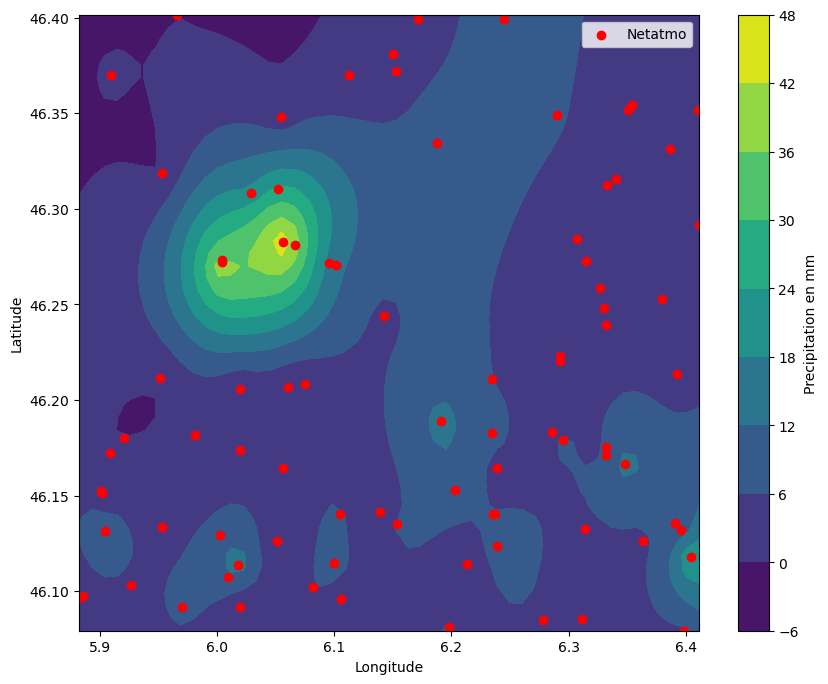

In [48]:


longitude_pws, latitude_pws, precipitation_pws = funcs.find_lon_lat_precip(df_pws_pcp_hourly,df_pws_coords)

x_lon = np.linspace(min(longitude_pws), max(longitude_pws), 50)
y_lat = np.linspace(min(latitude_pws), max(latitude_pws), 50)
grid_lon, grid_lat = np.meshgrid(x_lon, y_lat)

funcs.plot_interpolation(precipitation_pws, longitude_pws ,latitude_pws, x_lon,y_lat ,label ="Netatmo")

il y 72 stations acceptées le 2023-09-13 11:00:00


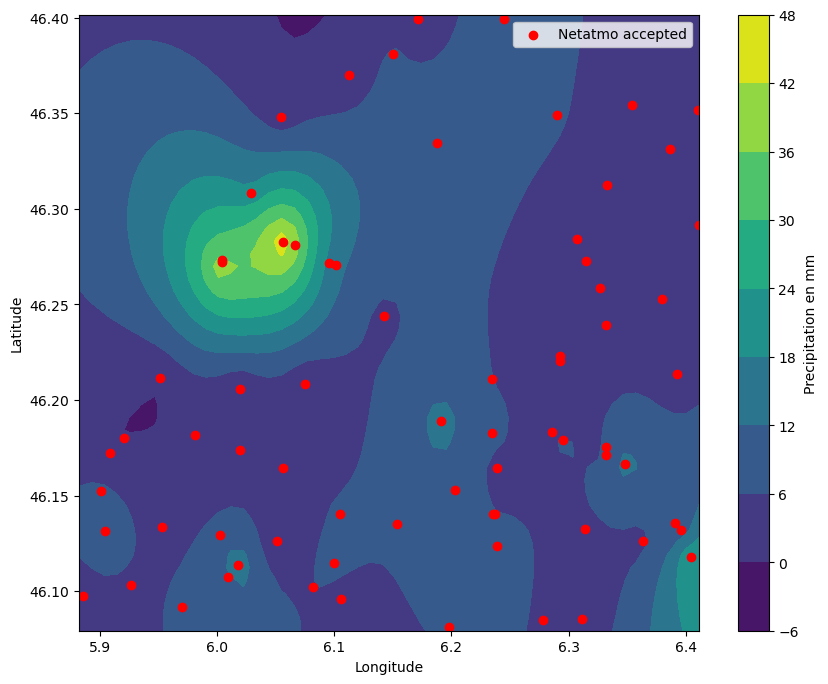

In [49]:
longitude_pws_accept, latitude_pws_accept, precipitation_pws_accept = funcs.find_lon_lat_precip(accepted_pws,df_pws_coords)

funcs.plot_interpolation(precipitation_pws_accept, longitude_pws_accept ,latitude_pws_accept, x_lon,y_lat ,label ="Netatmo accepted")


## Oceau

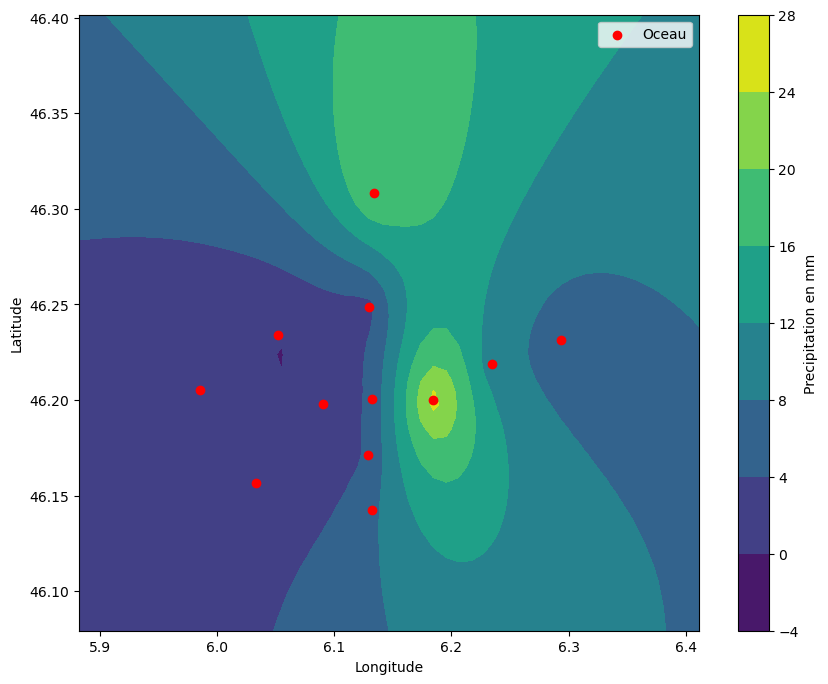

In [50]:

# Extract coordinates and values
longitude_oceau = df_prim_coords['lon'].values
latitude_oceau = df_prim_coords['lat'].values
precipitation_oceau = np.array(in_primary_pcp.iloc[3971].values, dtype=float)

funcs.plot_interpolation(precipitation_oceau, longitude_oceau ,latitude_oceau, x_lon,y_lat ,label="Oceau")

## Combinaison après le filtre EBF et Oceau

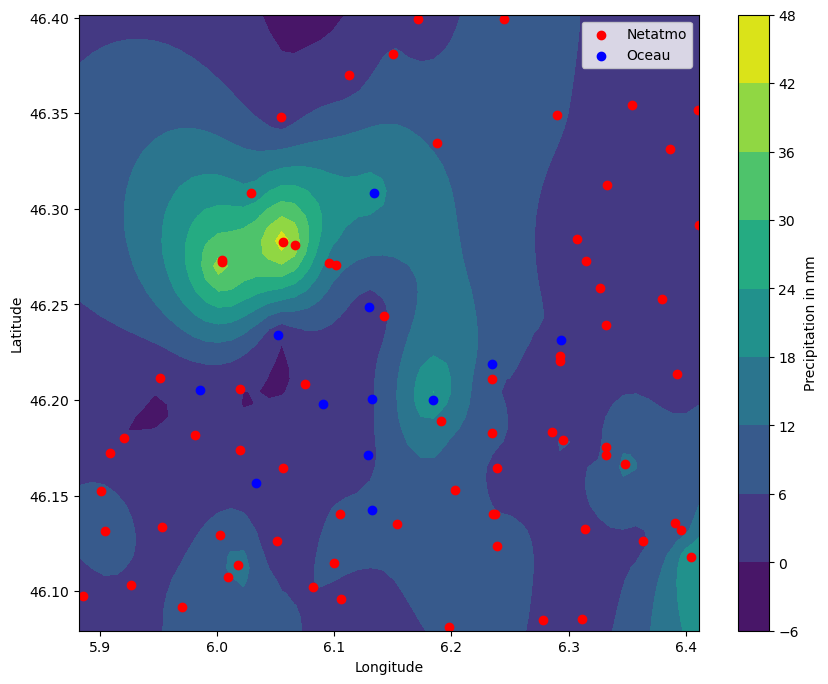

In [51]:
funcs.plot_combined_interp(longitude_pws_accept,longitude_oceau,latitude_pws_accept, latitude_oceau,
                         precipitation_pws_accept,precipitation_oceau,x_lon,y_lat)

## après la correction de biais

il y 72 stations acceptées le 2023-09-13 11:00:00


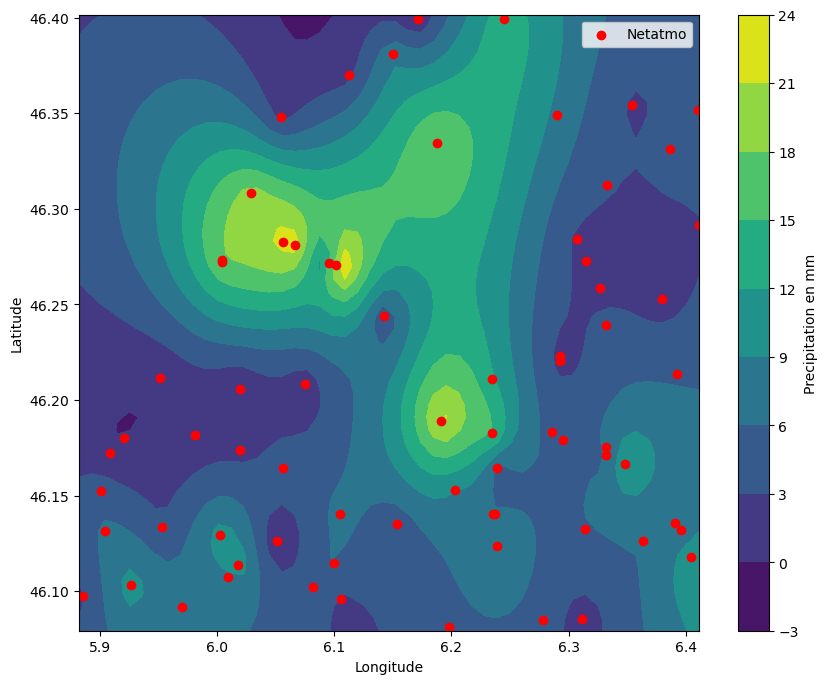

In [52]:
# Extract coordinates and values
longitude_pws_bias, latitude_pws_bias,  precipitation_pws_bias = funcs.find_lon_lat_precip(df_pws_bias_corrected,df_pws_coords)


funcs.plot_interpolation(precipitation_pws_bias, longitude_pws_bias ,latitude_pws_bias, x_lon,y_lat ,label ="Netatmo")

## Netatmo après le filtre EBF de PWS-pyqc

il y 68 stations acceptées le 2023-09-13 11:00:00


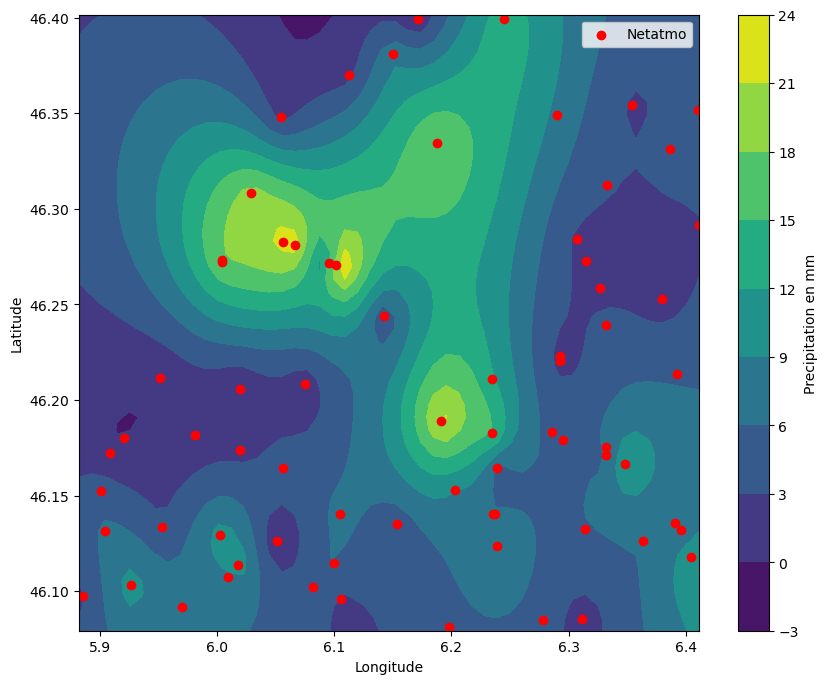

In [53]:

# Extract coordinates and values
longitude_pws_flag, latitude_pws_flag,  precipitation_pws_flag = funcs.find_lon_lat_precip(df_pws_flagged,df_pws_coords)

funcs.plot_interpolation(precipitation_pws_bias, longitude_pws_bias ,latitude_pws_bias, x_lon,y_lat ,label ="Netatmo")

## Netatmo marquées par PWS-pyqc + Oceau

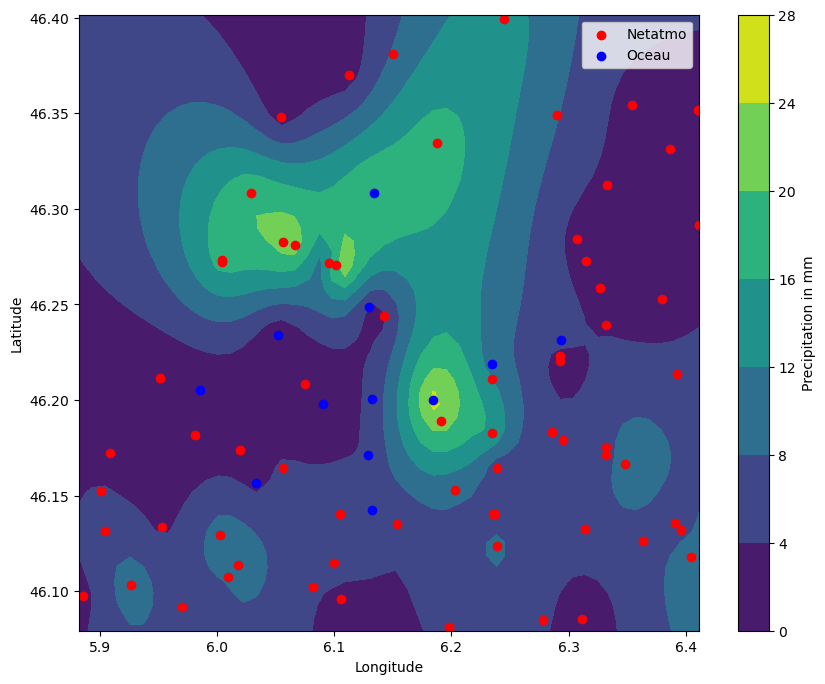

In [54]:
funcs.plot_combined_interp(longitude_pws_flag,longitude_oceau,latitude_pws_flag, latitude_oceau,
                         precipitation_pws_flag,precipitation_oceau,x_lon,y_lat)

## PWSQC interpolation

In [55]:
meta_pws = df_pws_coords[df_pws_coords.index.isin(accepted_pws.columns)]
meta_pws.to_csv("Data/meta_accepted.csv")

il y 79 stations acceptées le 2023-09-13 11:00:00


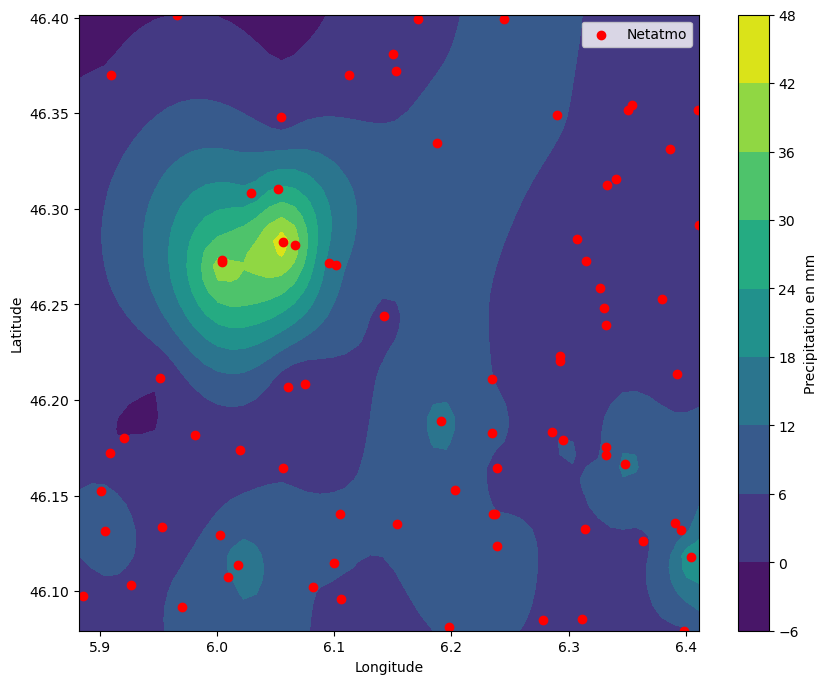

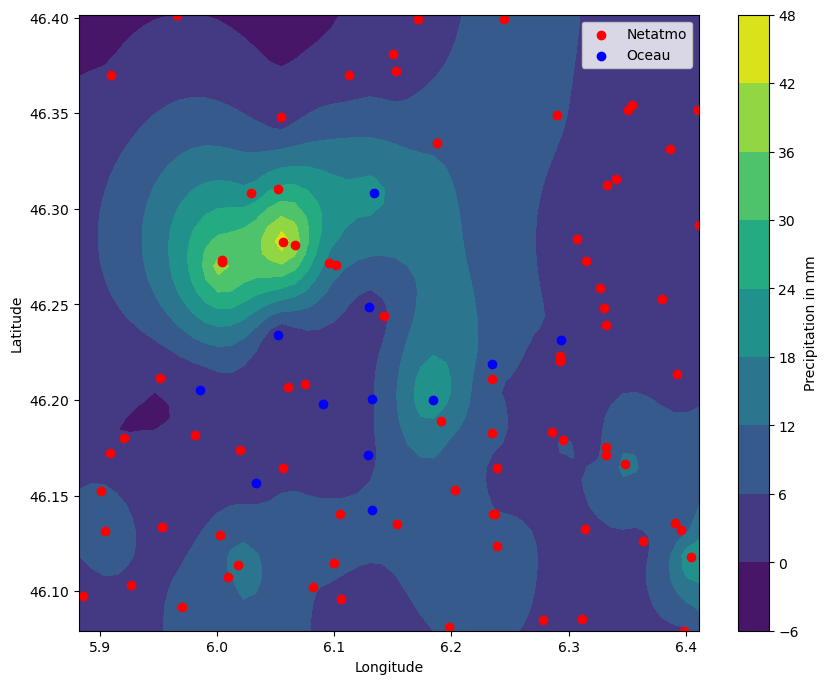

In [56]:

def plot_net_modified(algo_1_pws_pcp_hourly):
    '''
    plot d'abord les données interpolées seulement sur les stations Netatmo modifiées 
    puis plot les données interpolées sur les stations primaires + celles de Netatmo
    '''
    longitude_pws_algo1, latitude_pws_algo1,  precipitation_pws_algo1 = funcs.find_lon_lat_precip(algo_1_pws_pcp_hourly,df_pws_coords)

    funcs.plot_interpolation(precipitation_pws_algo1, longitude_pws_algo1 ,latitude_pws_algo1, x_lon,y_lat ,label ="Netatmo")
    funcs.plot_combined_interp(longitude_pws_algo1,longitude_oceau,latitude_pws_algo1, latitude_oceau,
                         precipitation_pws_algo1,precipitation_oceau,x_lon,y_lat)
plot_net_modified(algo_1_pws_pcp_hourly)

## interpolation de PWSQC avec la correction de biais

il y 76 stations acceptées le 2023-09-13 11:00:00


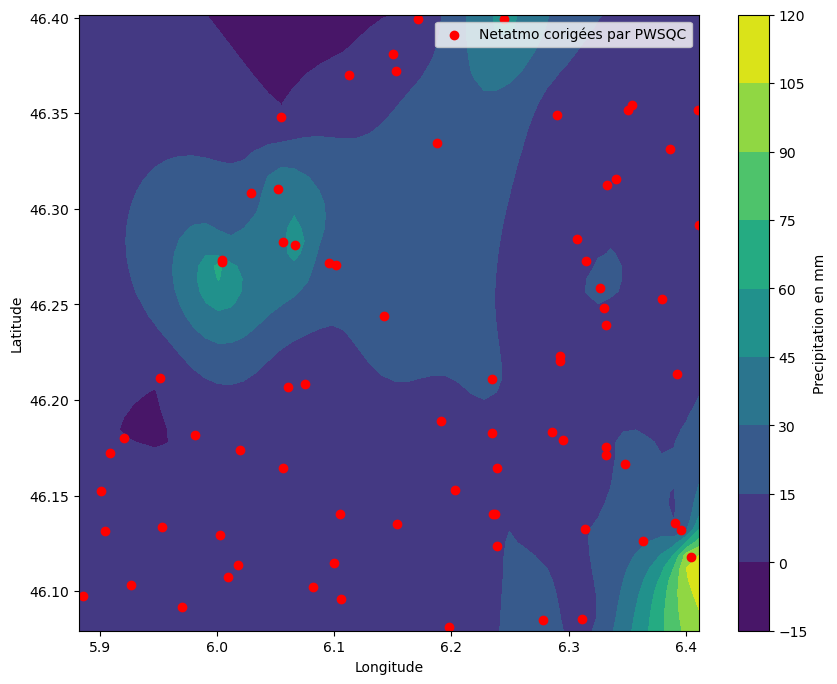

In [57]:

longitude_pws_bias_corrected, latitude_pws_bias_corrected,  precipitation_pws_bias_corrected = funcs.find_lon_lat_precip(bias_corrected_strict,df_pws_coords)

funcs.plot_interpolation(precipitation_pws_bias_corrected, longitude_pws_bias_corrected ,latitude_pws_bias_corrected, x_lon,y_lat ,label ="Netatmo corigées par PWSQC")

## Interpolation sur les données combinées des deux algorithmes

il y 68 stations acceptées le 2023-09-13 11:00:00


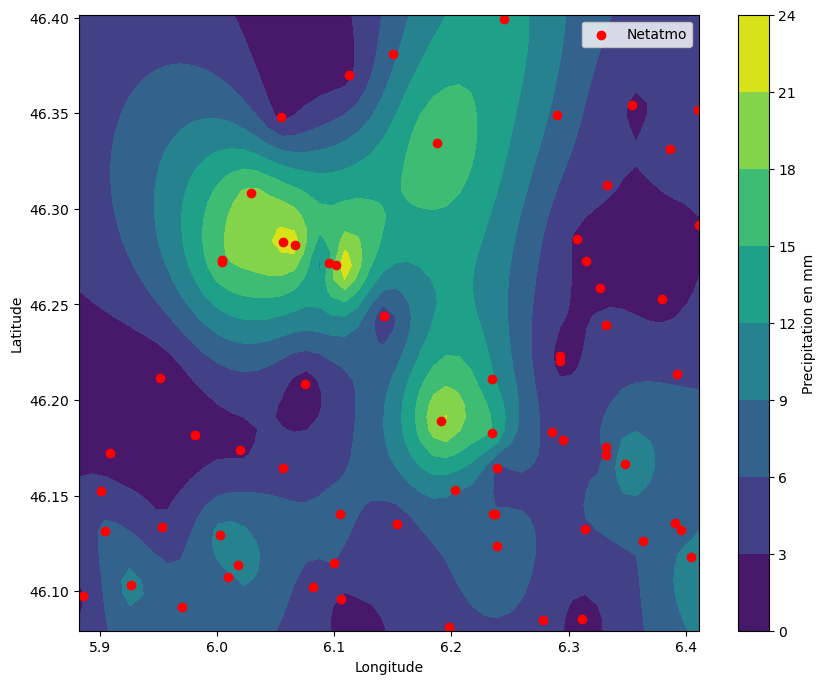

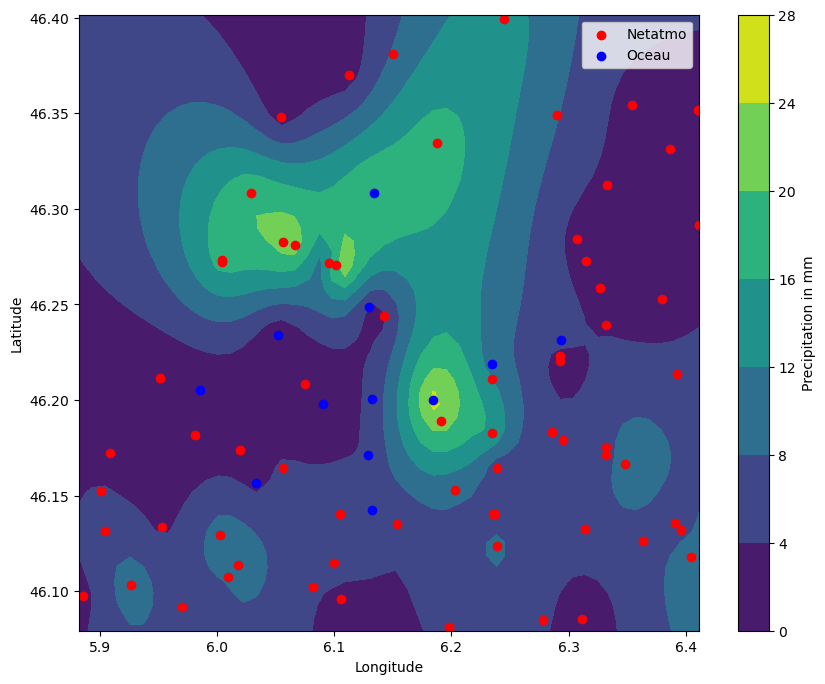

In [58]:

plot_net_modified(final_merged)

## Plotting all together !

In [59]:
#fixe la couleur de la barre de couleur
CMAP = "viridis"

In [60]:
#change la taille du texte des plots
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})

### Avec PWSQC en filtre strict après la correction de biais

algo1
il y 76 stations acceptées le 2023-09-13 11:00:00
final_merged
il y 68 stations acceptées le 2023-09-13 11:00:00


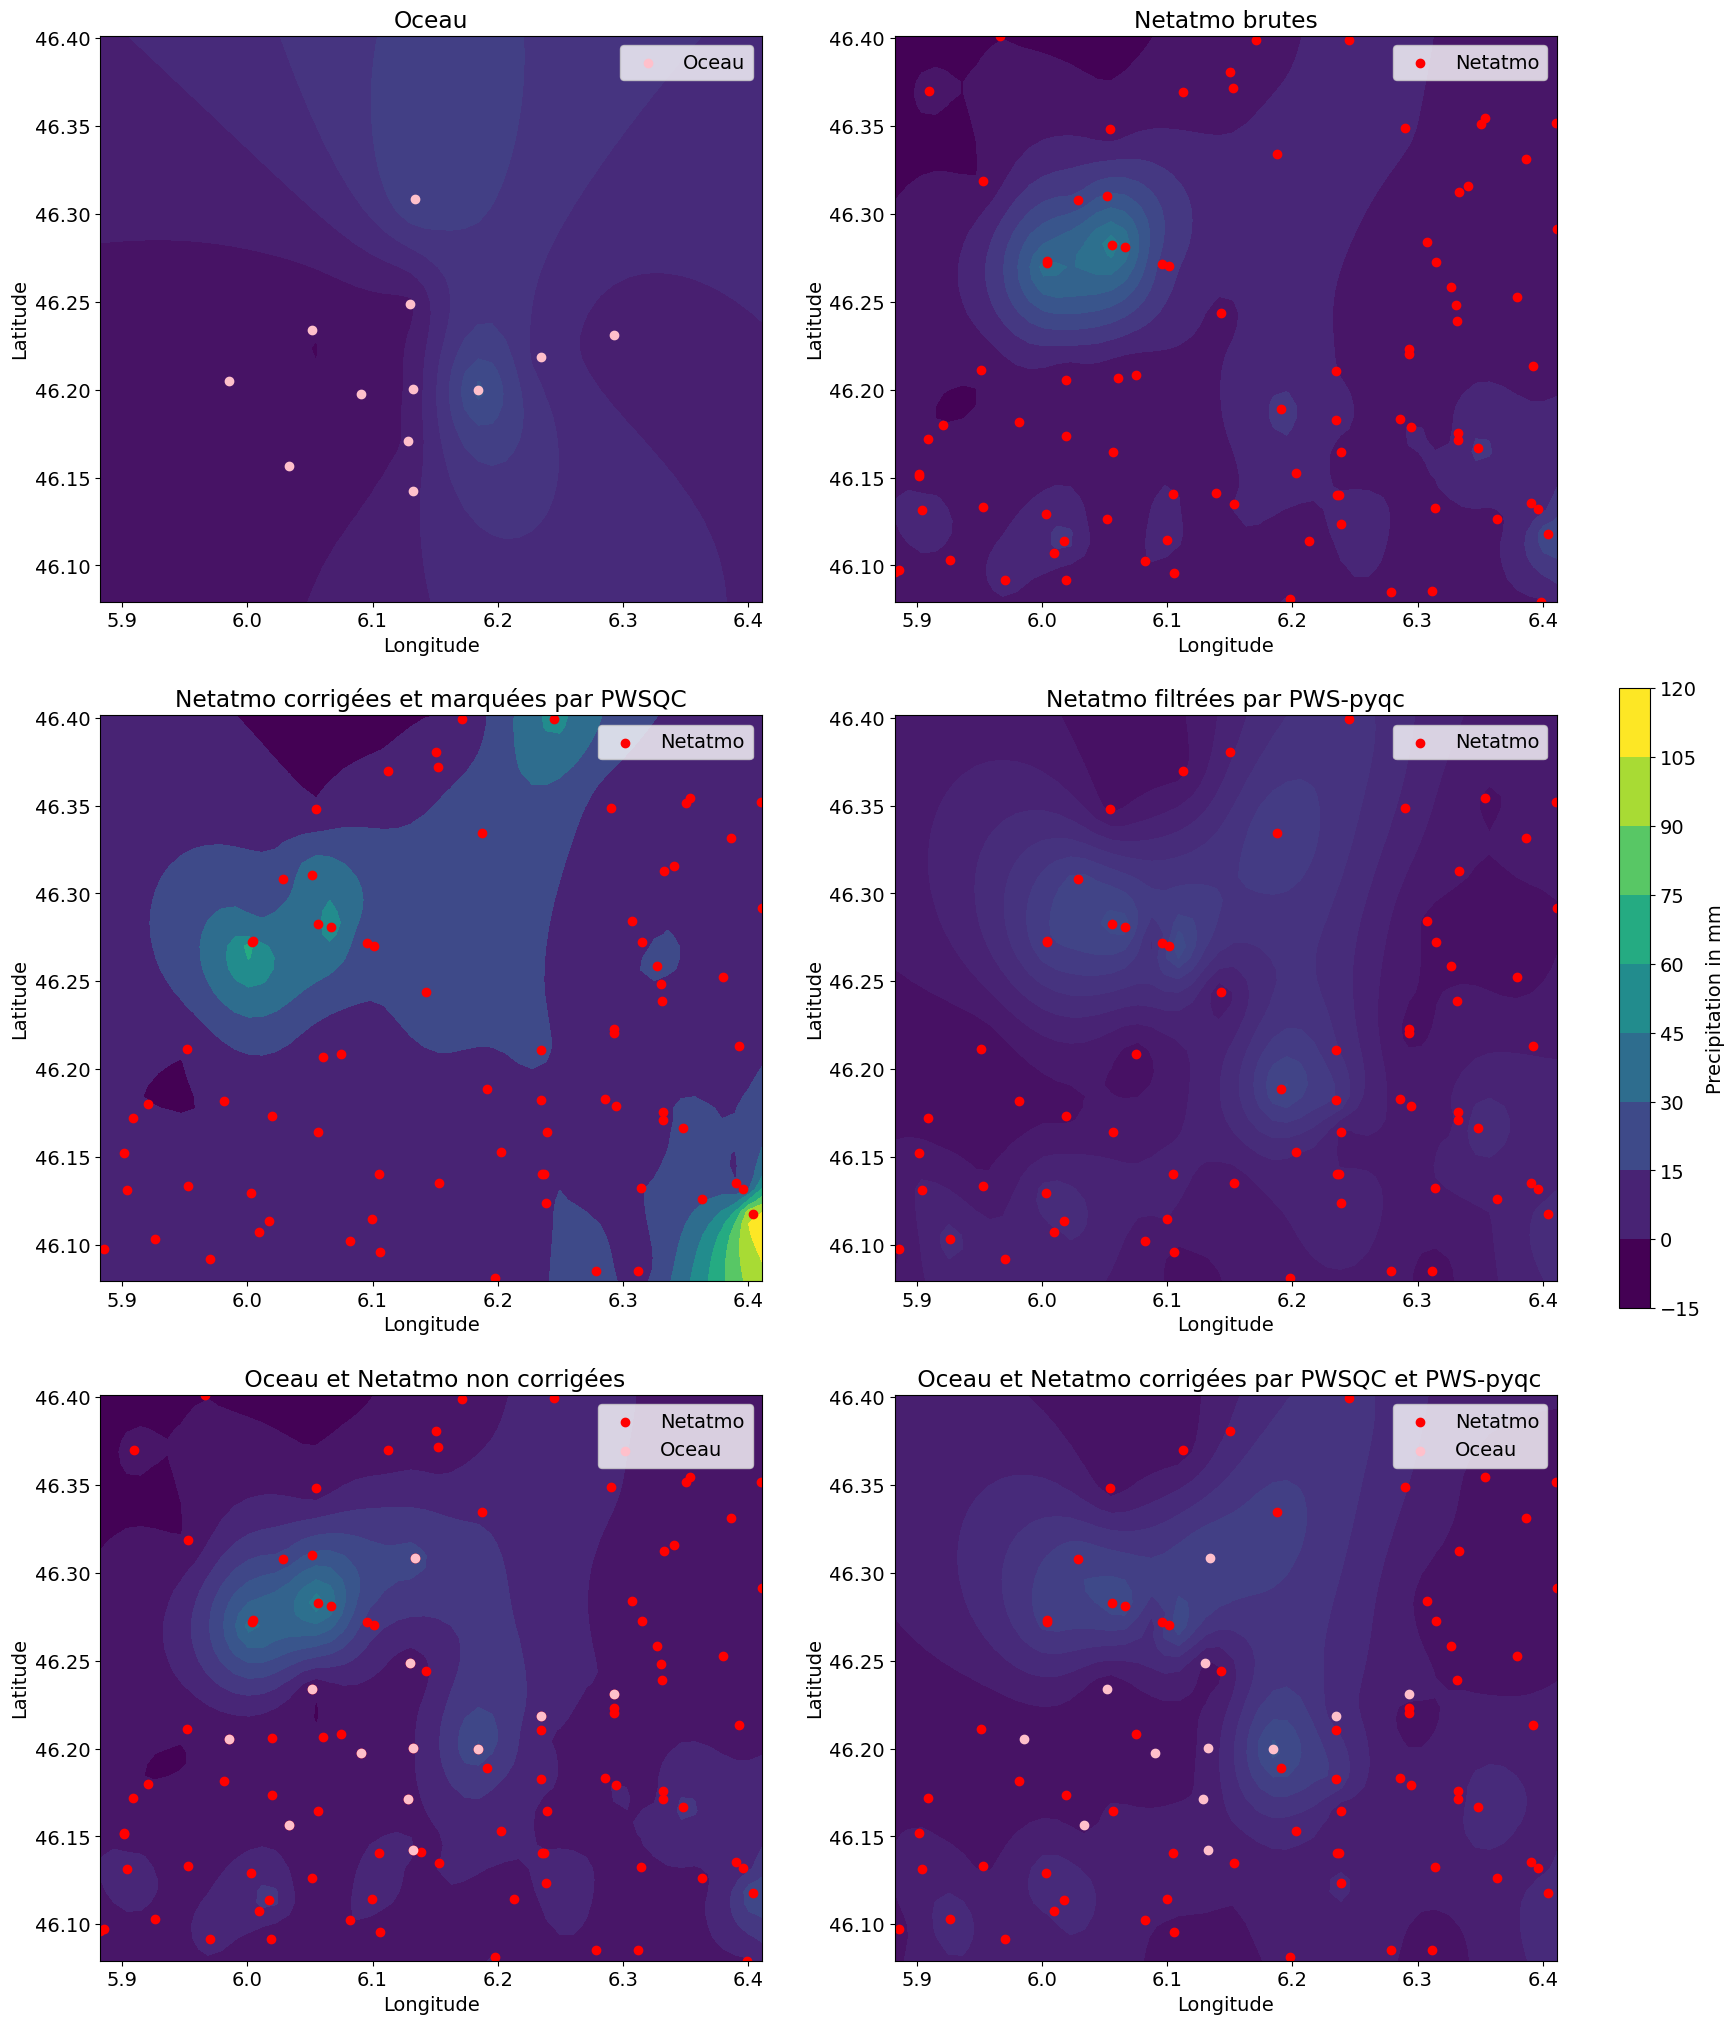

In [61]:

combined_longitude_algo2 = np.concatenate((longitude_pws_flag, longitude_oceau))
combined_latitude_algo2 = np.concatenate((latitude_pws_flag, latitude_oceau))
combined_precipitation_algo2 = np.concatenate((precipitation_pws_flag, precipitation_oceau))

# Extract coordinates and values
print("algo1")
longitude_pws_algo1, latitude_pws_algo1,  precipitation_pws_algo1 = funcs.find_lon_lat_precip(bias_corrected_strict,df_pws_coords)
print("final_merged")
# Extract coordinates and values
longitude_pws_merged, latitude_pws_merged,  precipitation_pws_merged = funcs.find_lon_lat_precip(final_merged,df_pws_coords)

combined_longitude_brut = np.concatenate((longitude_pws, longitude_oceau))
combined_latitude_brut= np.concatenate((latitude_pws, latitude_oceau))
combined_precipitation_brut = np.concatenate((precipitation_pws, precipitation_oceau))


combined_longitude_final= np.concatenate((longitude_pws_merged, longitude_oceau))
combined_latitude_final= np.concatenate((latitude_pws_merged, latitude_oceau))
combined_precipitation_final = np.concatenate((precipitation_pws_merged, precipitation_oceau))

# Interpolated data
pws_z = funcs.ordinary_krig(longitude_pws, latitude_pws, precipitation_pws, x_lon, y_lat)
oceau_z = funcs.ordinary_krig(longitude_oceau, latitude_oceau, precipitation_oceau, x_lon, y_lat)

algo1_z = funcs.ordinary_krig(longitude_pws_algo1, latitude_pws_algo1, precipitation_pws_algo1, x_lon, y_lat)
algo2_z = funcs.ordinary_krig(longitude_pws_flag, latitude_pws_flag, precipitation_pws_flag, x_lon, y_lat)

net_oceau_brut_z = funcs.ordinary_krig(combined_longitude_brut, combined_latitude_brut, combined_precipitation_brut, x_lon, y_lat)
final_interpolated = funcs.ordinary_krig(combined_longitude_final, combined_latitude_final, combined_precipitation_final, x_lon, y_lat)


# Common color limits
vmin = min(np.min(pws_z), np.min(oceau_z), np.min(algo2_z),np.min(algo1_z),np.min(net_oceau_brut_z), np.min(final_interpolated))
vmax = max(np.max(pws_z), np.max(oceau_z), np.max(algo2_z),np.max(algo1_z),np.max(net_oceau_brut_z), np.max(final_interpolated))

# Create a figure with a specific size
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 25))


# Plot interpolation for oceau data on the first subplot
contour_oceau = axes[0,0].contourf(grid_lon, grid_lat, oceau_z, cmap=CMAP, vmin=vmin, vmax=vmax)
axes[0,0].scatter(longitude_oceau, latitude_oceau, c='pink', marker='o', label='Oceau')
axes[0,0].set_title("Oceau")
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')
axes[0,0].legend()

# Plot interpolation for pws data on the first subplot
contour_pws = axes[0,1].contourf(grid_lon, grid_lat, pws_z, cmap=CMAP, vmin=vmin, vmax=vmax)
axes[0,1].scatter(longitude_pws, latitude_pws, c='red', marker='o', label='Netatmo')
axes[0,1].set_title('Netatmo brutes')
axes[0,1].set_xlabel('Longitude')
axes[0,1].set_ylabel('Latitude')
axes[0,1].legend()



# Plot combined interpolation on the third subplot
contour_combined_pwsqc = axes[1,0].contourf(grid_lon, grid_lat, algo1_z, cmap=CMAP, vmin=vmin, vmax=vmax)
axes[1,0].scatter(longitude_pws_algo1, latitude_pws_algo1, c='red', marker='o', label='Netatmo')
axes[1,0].set_title('Netatmo corrigées et marquées par PWSQC')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
axes[1,0].legend()

# Plot combined interpolation on the third subplot
contour_combined = axes[1,1].contourf(grid_lon, grid_lat, algo2_z, cmap=CMAP, vmin=vmin, vmax=vmax)
axes[1,1].scatter(longitude_pws_flag, latitude_pws_flag, c='red', marker='o', label='Netatmo')
axes[1,1].set_title('Netatmo filtrées par PWS-pyqc')
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel('Latitude')
axes[1,1].legend()

# Plot combined interpolation on the third subplot
contour_combined = axes[2,0].contourf(grid_lon, grid_lat, net_oceau_brut_z, cmap=CMAP, vmin=vmin, vmax=vmax)
axes[2,0].scatter(combined_longitude_brut, combined_latitude_brut, c='red', marker='o', label='Netatmo')
axes[2,0].scatter(longitude_oceau, latitude_oceau, c='pink', marker='o', label='Oceau')
axes[2,0].set_title(' Oceau et Netatmo non corrigées')
axes[2,0].set_xlabel('Longitude')
axes[2,0].set_ylabel('Latitude')
axes[2,0].legend()

# Plot combined interpolation on the third subplot
contour_combined = axes[2,1].contourf(grid_lon, grid_lat, final_interpolated, cmap=CMAP, vmin=vmin, vmax=vmax)
axes[2,1].scatter(longitude_pws_merged, latitude_pws_merged, c='red', marker='o', label='Netatmo')
axes[2,1].scatter(longitude_oceau, latitude_oceau, c='pink', marker='o', label='Oceau')
axes[2,1].set_title(' Oceau et Netatmo corrigées par PWSQC et PWS-pyqc')
axes[2,1].set_xlabel('Longitude')
axes[2,1].set_ylabel('Latitude')
axes[2,1].legend()


# Add a single colorbar
cbar = fig.colorbar(contour_combined_pwsqc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04, label='Precipitation in mm')

#plt.tight_layout()
#plt.suptitle('Interpolation of Precipitation using Ordinary Kriging', y=1.05)
plt.show()

La valeur à 100 de PWSQC limite la lisibilité des autres interpolations

### Filtre strict de PWSQC sans la correction de biais

algo1
il y 79 stations acceptées le 2023-09-13 11:00:00
final_merged
il y 68 stations acceptées le 2023-09-13 11:00:00


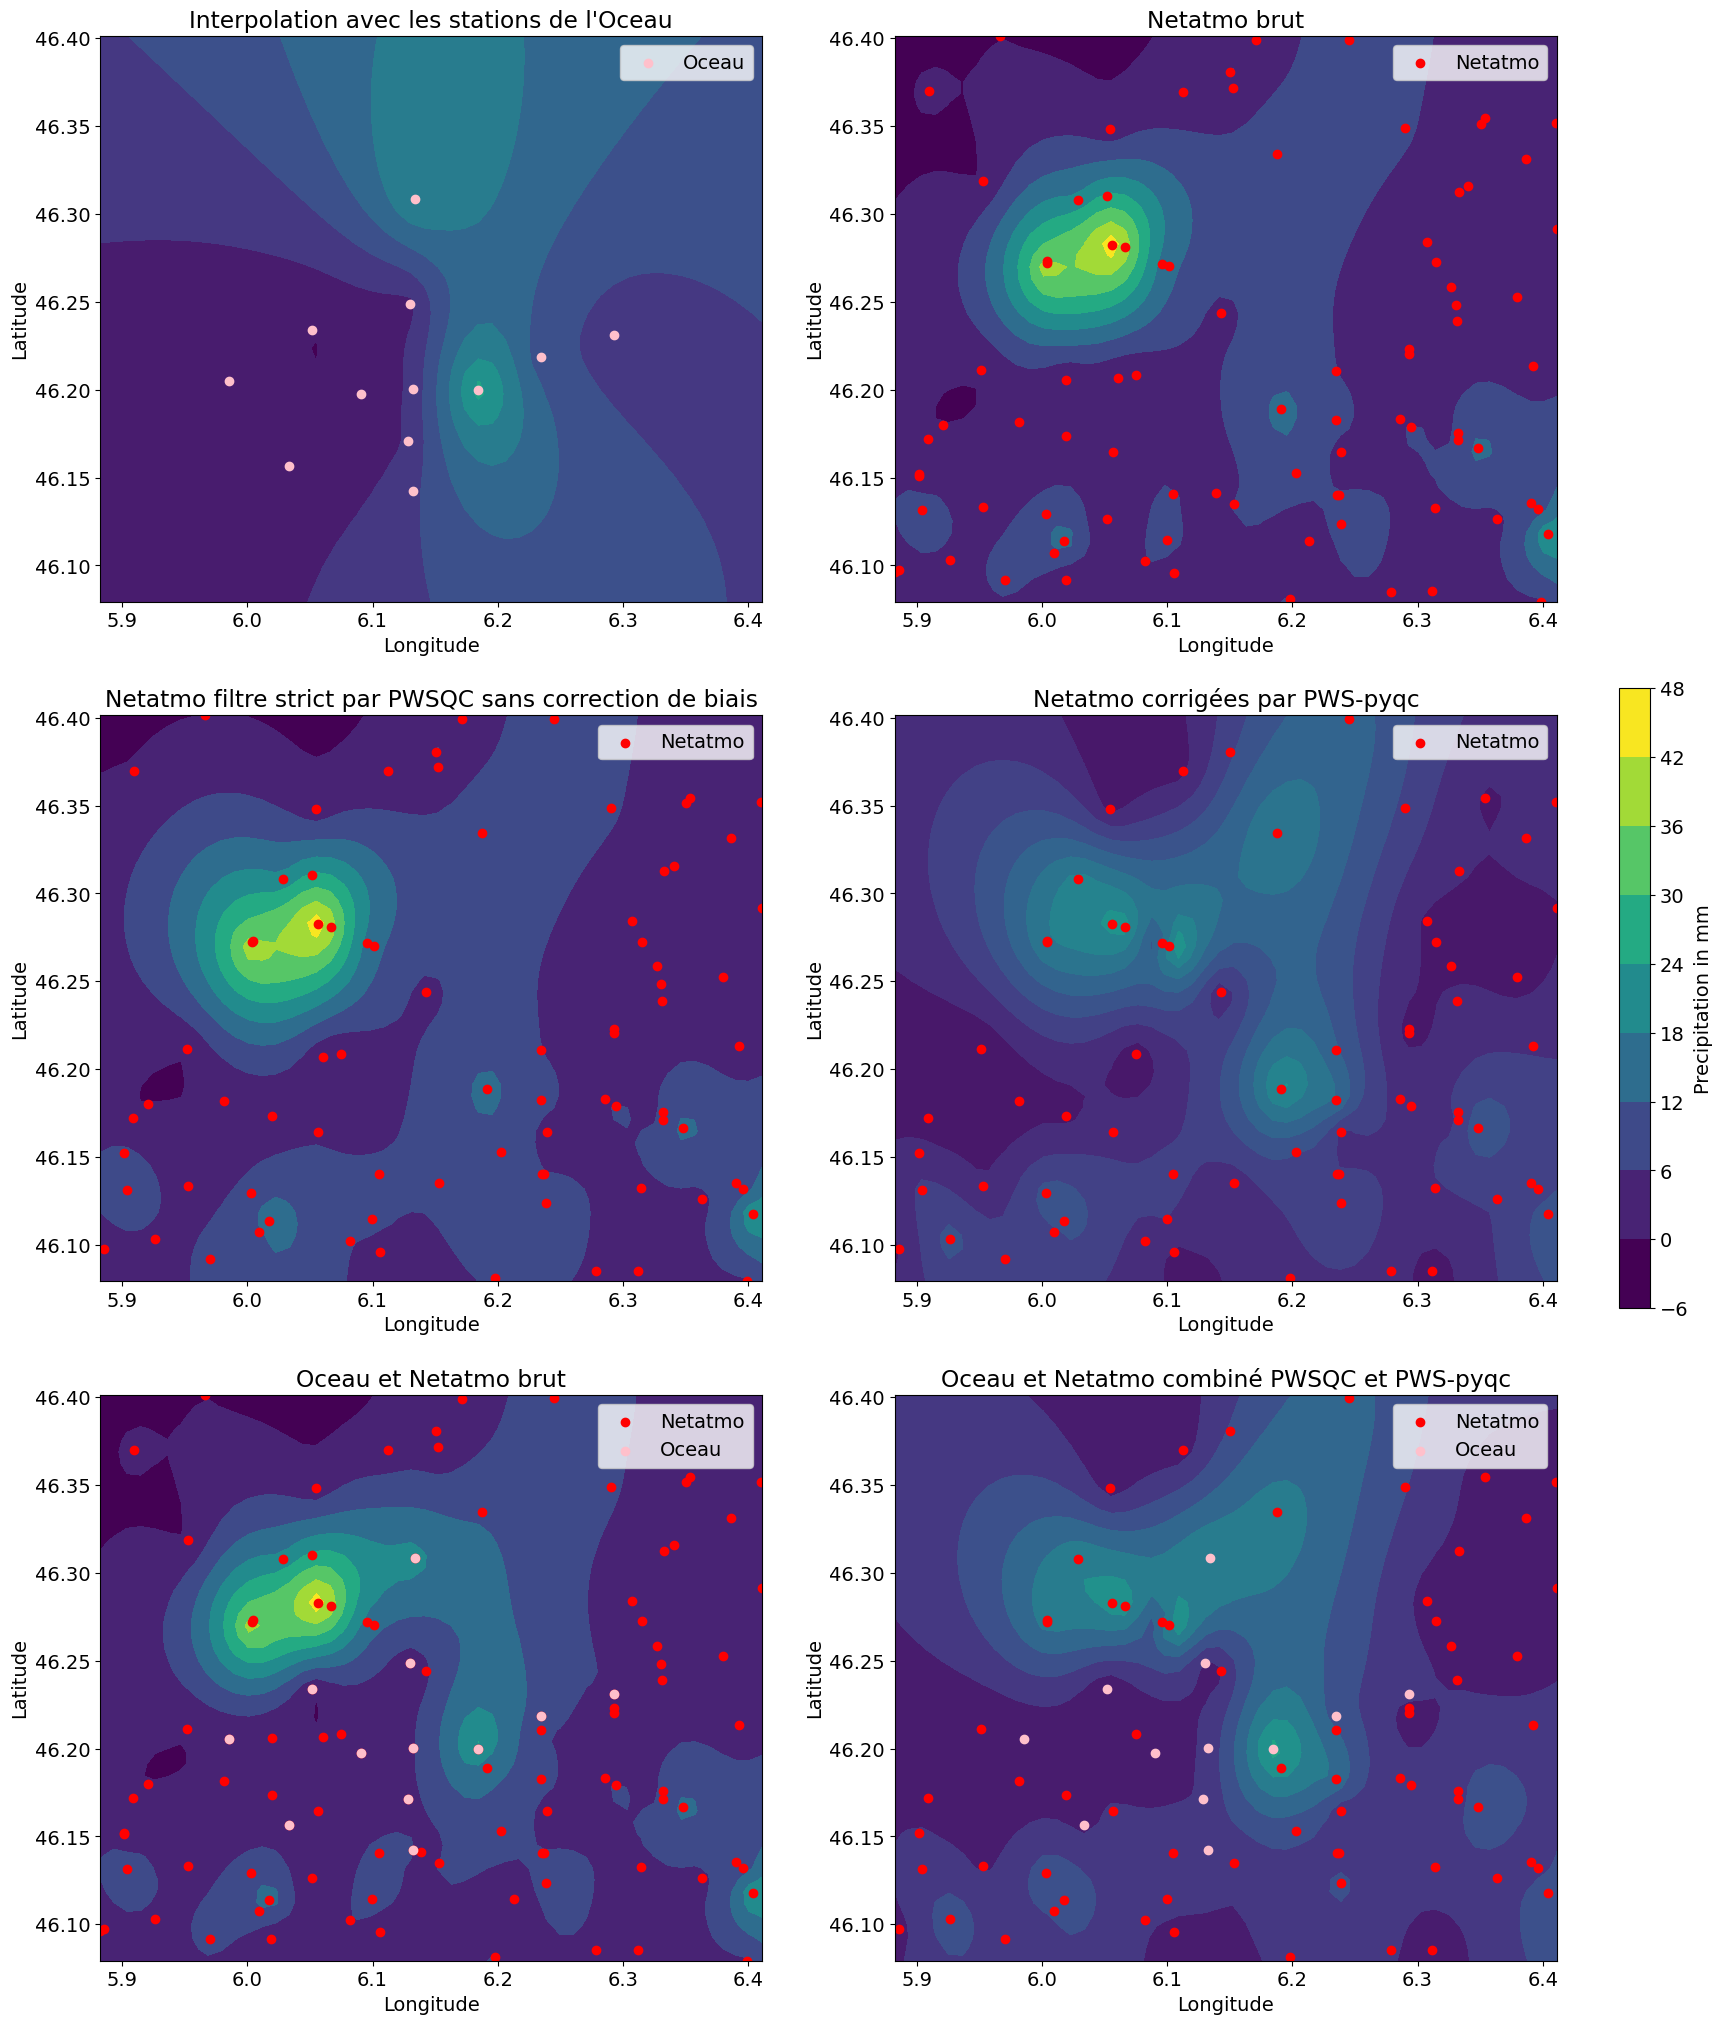

In [62]:

combined_longitude_algo2 = np.concatenate((longitude_pws_flag, longitude_oceau))
combined_latitude_algo2 = np.concatenate((latitude_pws_flag, latitude_oceau))
combined_precipitation_algo2 = np.concatenate((precipitation_pws_flag, precipitation_oceau))

# Extract coordinates and values
print("algo1")
longitude_pws_algo1, latitude_pws_algo1,  precipitation_pws_algo1 = funcs.find_lon_lat_precip(algo_1_pws_pcp_hourly,df_pws_coords)
print("final_merged")
# Extract coordinates and values
longitude_pws_merged, latitude_pws_merged,  precipitation_pws_merged = funcs.find_lon_lat_precip(final_merged,df_pws_coords)

combined_longitude_brut = np.concatenate((longitude_pws, longitude_oceau))
combined_latitude_brut= np.concatenate((latitude_pws, latitude_oceau))
combined_precipitation_brut = np.concatenate((precipitation_pws, precipitation_oceau))


combined_longitude_final= np.concatenate((longitude_pws_merged, longitude_oceau))
combined_latitude_final= np.concatenate((latitude_pws_merged, latitude_oceau))
combined_precipitation_final = np.concatenate((precipitation_pws_merged, precipitation_oceau))

# Interpolated data
pws_z = funcs.ordinary_krig(longitude_pws, latitude_pws, precipitation_pws, x_lon, y_lat)
oceau_z = funcs.ordinary_krig(longitude_oceau, latitude_oceau, precipitation_oceau, x_lon, y_lat)

algo1_z = funcs.ordinary_krig(longitude_pws_algo1, latitude_pws_algo1, precipitation_pws_algo1, x_lon, y_lat)
algo2_z = funcs.ordinary_krig(longitude_pws_flag, latitude_pws_flag, precipitation_pws_flag, x_lon, y_lat)

net_oceau_brut_z = funcs.ordinary_krig(combined_longitude_brut, combined_latitude_brut, combined_precipitation_brut, x_lon, y_lat)
final_interpolated = funcs.ordinary_krig(combined_longitude_final, combined_latitude_final, combined_precipitation_final, x_lon, y_lat)


# Common color limits
vmin = min(np.min(pws_z), np.min(oceau_z), np.min(algo2_z),np.min(algo1_z),np.min(net_oceau_brut_z), np.min(final_interpolated))
vmax = max(np.max(pws_z), np.max(oceau_z), np.max(algo2_z),np.max(algo1_z),np.max(net_oceau_brut_z), np.max(final_interpolated))

# Create a figure with a specific size
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 25))


# Plot interpolation for oceau data on the first subplot
contour_oceau = axes[0,0].contourf(grid_lon, grid_lat, oceau_z, cmap=CMAP, vmin=vmin, vmax=vmax)
axes[0,0].scatter(longitude_oceau, latitude_oceau, c='pink', marker='o', label='Oceau')
axes[0,0].set_title("Interpolation avec les stations de l'Oceau")
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')
axes[0,0].legend()

# Plot interpolation for pws data on the first subplot
contour_pws = axes[0,1].contourf(grid_lon, grid_lat, pws_z, cmap=CMAP, vmin=vmin, vmax=vmax)
axes[0,1].scatter(longitude_pws, latitude_pws, c='red', marker='o', label='Netatmo')
axes[0,1].set_title('Netatmo brut')
axes[0,1].set_xlabel('Longitude')
axes[0,1].set_ylabel('Latitude')
axes[0,1].legend()



# Plot combined interpolation on the third subplot
contour_combined = axes[1,0].contourf(grid_lon, grid_lat, algo1_z, cmap=CMAP, vmin=vmin, vmax=vmax)
axes[1,0].scatter(longitude_pws_algo1, latitude_pws_algo1, c='red', marker='o', label='Netatmo')
axes[1,0].set_title('Netatmo filtre strict par PWSQC sans correction de biais')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
axes[1,0].legend()

# Plot combined interpolation on the third subplot
contour_combined = axes[1,1].contourf(grid_lon, grid_lat, algo2_z, cmap=CMAP, vmin=vmin, vmax=vmax)
axes[1,1].scatter(longitude_pws_flag, latitude_pws_flag, c='red', marker='o', label='Netatmo')
axes[1,1].set_title('Netatmo corrigées par PWS-pyqc')
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel('Latitude')
axes[1,1].legend()

# Plot combined interpolation on the third subplot
contour_combined = axes[2,0].contourf(grid_lon, grid_lat, net_oceau_brut_z, cmap=CMAP, vmin=vmin, vmax=vmax)
axes[2,0].scatter(combined_longitude_brut, combined_latitude_brut, c='red', marker='o', label='Netatmo')
axes[2,0].scatter(longitude_oceau, latitude_oceau, c='pink', marker='o', label='Oceau')
axes[2,0].set_title('Oceau et Netatmo brut')
axes[2,0].set_xlabel('Longitude')
axes[2,0].set_ylabel('Latitude')
axes[2,0].legend()

# Plot combined interpolation on the third subplot
contour_combined = axes[2,1].contourf(grid_lon, grid_lat, final_interpolated, cmap=CMAP, vmin=vmin, vmax=vmax)
axes[2,1].scatter(longitude_pws_merged, latitude_pws_merged, c='red', marker='o', label='Netatmo')
axes[2,1].scatter(longitude_oceau, latitude_oceau, c='pink', marker='o', label='Oceau')
axes[2,1].set_title('Oceau et Netatmo combiné PWSQC et PWS-pyqc')
axes[2,1].set_xlabel('Longitude')
axes[2,1].set_ylabel('Latitude')
axes[2,1].legend()


# Add a single colorbar
cbar = fig.colorbar(contour_pws, ax=axes, orientation='vertical', fraction=0.02, pad=0.04, label='Precipitation in mm')

#plt.tight_layout()
#plt.suptitle('Interpolation of Precipitation using Ordinary Kriging', y=1.05)
plt.show()

Création d'un dataframe pour pouvoir effectuer le plot des doubles cumuls sur plot.R

In [63]:
meta_pws = df_pws_coords[df_pws_coords.index.isin(df_pws_flagged.columns)]

In [64]:
meta_pws.to_csv("Data/Output_algo_2/Meta_pws_end_algo2.csv")

# Séries temporelles

c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

Text(0, 0.5, 'précipitation moyenne en mm')

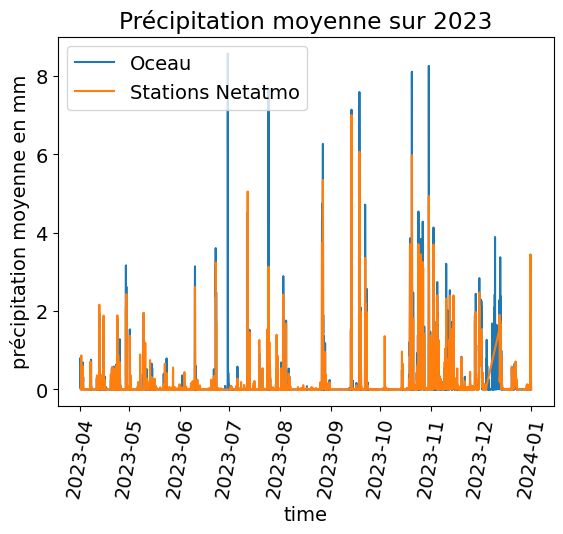

In [65]:
stat_primary = in_primary_pcp.copy(deep=True)
stat_flagged_pws = df_pws_pcp_hourly.copy(deep=True)

stat_primary['mean'] = in_primary_pcp.mean(axis=1, numeric_only=True, skipna=True)
stat_flagged_pws["mean"] = stat_flagged_pws.mean(axis=1, numeric_only=True, skipna=True)

sns.lineplot(data = stat_primary, x= "time", y = "mean", label = "Oceau")
sns.lineplot(data = stat_flagged_pws, x= "time", y = "mean", label = "Stations Netatmo")
plt.xticks(rotation=80) 
plt.title("Précipitation moyenne sur 2023")
plt.ylabel("précipitation moyenne en mm")

Série temporelle une fois les stations acceptées et corrigées par les deux algorithmes

In [66]:
stat_primary = in_primary_pcp.copy(deep=True)
stat_flagged_pws = final_merged.copy(deep=True)

stat_primary['mean'] = in_primary_pcp.mean(axis=1, numeric_only=True, skipna=True)
stat_flagged_pws["mean"] = stat_flagged_pws.mean(axis=1, numeric_only=True, skipna=True)

sns.lineplot(data = stat_primary, x= "time", y = "mean", label = "Oceau")
sns.lineplot(data = stat_flagged_pws, x= "time", y = "mean", label = "Station Netatmo acceptées et corrigées")
plt.xticks(rotation=80) 
plt.title("Précipitation moyenne sur 2023")
plt.ylabel("précipitation moyenne en mm")

c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

Text(0, 0.5, 'précipitation moyenne en mm')

Zooming in

In [67]:
stat_primary

AR   BA   CE   CR   DD   ER   ES   FO   GF   LA   LC  \
time                                                                         
2023-04-01 00:00:00  0.1  0.1  0.2  0.3  0.3  0.6  0.3  0.1  0.1  0.2  0.1   
2023-04-01 01:00:00  0.4  0.1  0.3  0.7  0.7  1.5  1.4  0.6  0.6  0.1  0.0   
2023-04-01 02:00:00  0.0  0.0  0.0  0.1  0.0  0.0  0.1  0.0  0.1  0.0  0.1   
2023-04-01 03:00:00  0.2  0.0  0.1  0.3  0.0  0.8  0.1  0.4  0.0  0.1  0.1   
2023-04-01 04:00:00  0.5  0.3  0.4  0.5  0.5  0.9  0.6  0.5  0.2  0.2  0.3   
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2023-12-31 19:00:00  0.1  0.1  0.0  0.1  0.1  0.0  0.1  0.0  0.1  0.0  0.1   
2023-12-31 20:00:00  1.2  1.6  1.2  1.2  1.3  0.7  1.0  1.6  1.4  1.1  1.4   
2023-12-31 21:00:00  0.1  0.1  0.1  0.0  0.0  0.1  0.0  0.0  0.1  0.2  0.0   
2023-12-31 22:00:00  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0   
2023-12-31 23:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                      SA      mean  
time                                
2023-04-01 00:00:00  0.1  0.208333  
2023-04-01 01:00:00  0.1  0.541667  
2023-04-01 02:00:00  0.0  0.033333  
2023-04-01 03:00:00  0.0  0.175000  
2023-04-01 04:00:00  0.5  0.450000  
...                  ...       ...  
2023-12-31 19:00:00  0.3  0.083333  
2023-12-31 20:00:00  0.1  1.150000  
2023-12-31 21:00:00  0.1  0.066667  
2023-12-31 22:00:00  0.0  0.008333  
2023-12-31 23:00:00  0.0  0.000000  

[6600 rows x 13 columns]

c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arian\anaconda3\envs\design\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

Text(0.5, 1.0, 'Précipitations moyenne le 13 septembre 2023')

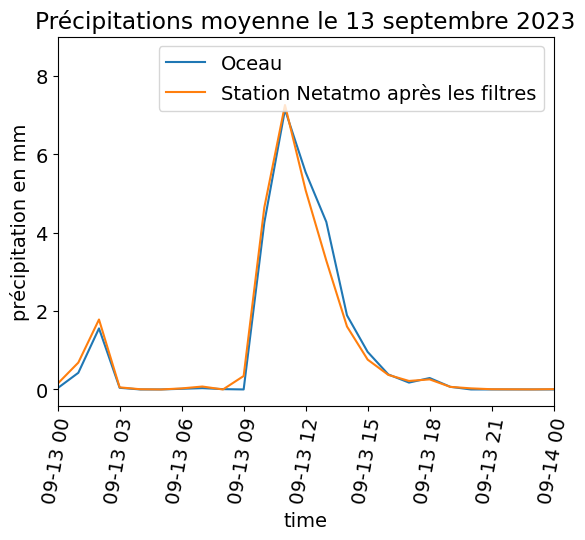

In [68]:

stat_primary = in_primary_pcp.copy(deep=True)
stat_flagged_pws = final_merged.copy(deep=True)

stat_primary['mean'] = in_primary_pcp.mean(axis=1, numeric_only=True, skipna=True)
stat_flagged_pws["mean"] = stat_flagged_pws.mean(axis=1, numeric_only=True, skipna=True)

sns.lineplot(data = stat_primary, x= "time", y = "mean", label = "Oceau")
sns.lineplot(data = stat_flagged_pws, x= "time", y = "mean", label = "Station Netatmo après les filtres")

# Convert date strings to Timestamp objects
start_date = pd.Timestamp("2023-09-13")
end_date = pd.Timestamp("2023-09-14")
# Zoom in on a specific region
plt.xlim(start_date, end_date)  # Set x-axis limits
plt.ylabel("précipitation en mm")
plt.xticks(rotation=80) 
plt.title("Précipitations moyenne le 13 septembre 2023")

# Double cumul plot

Comparaison de la station netatmo  05_00_00_00_97_94 and de la station oceau  CE qui sont proches l'une de l'autre

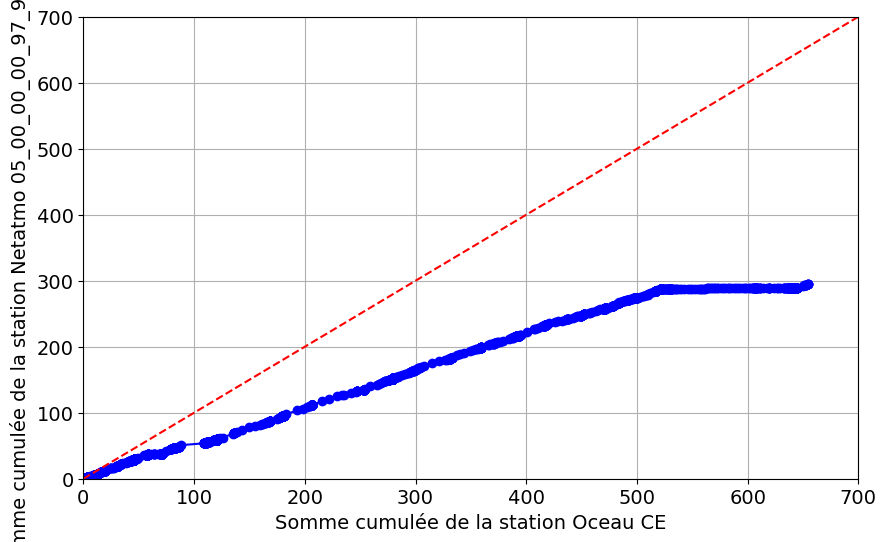

In [69]:
df_cumsum = funcs.create_cumsum_df(df_pws_pcp_hourly,in_primary_pcp,"05_00_00_00_97_94","CE")
funcs.plot_double_mass_curve(df_cumsum['Cumulative_pws'] , df_cumsum['Cumulative_prim'],"05_00_00_00_97_94 brute","CE",0,700)

In [70]:
len(df_cumsum['Cumulative_prim'])

5246

In [71]:
df_cumsum = funcs.create_cumsum_df(df_pws_flagged,in_primary_pcp,"05_00_00_00_97_94","CE")
funcs.plot_double_mass_curve(df_cumsum['Cumulative_pws'] , df_cumsum['Cumulative_prim'],"05_00_00_00_97_94 traitée par PWS-pyqc","CE",0,700)

In [72]:
len(df_cumsum['Cumulative_prim'])

5069

In [73]:
df_cumsum = funcs.create_cumsum_df(bias_corrected_strict,in_primary_pcp,"05_00_00_00_97_94","CE")
funcs.plot_double_mass_curve(df_cumsum['Cumulative_pws'] , df_cumsum['Cumulative_prim'],"05_00_00_00_97_94 traitée par PWSQC","CE",0,700)

In [74]:
len(df_cumsum['Cumulative_prim'])

4185

In [75]:
df_cumsum = funcs.create_cumsum_df(final_merged_strict,in_primary_pcp,"05_00_00_00_97_94","CE")
funcs.plot_double_mass_curve(df_cumsum['Cumulative_pws'] , df_cumsum['Cumulative_prim'],"05_00_00_00_97_94 traitée par PWSQC","CE",0,700)

In [76]:
len(df_cumsum['Cumulative_prim'])

4123